In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
card_df = pd.read_csv('./creditcard.csv')
card_df.head(3)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


### 데이터 일차 가공 및 모델 학습/예측/평가

* 불필요한 Time피처 삭제

In [3]:
# 인자로 입력받은 DataFrame을 복사 한 뒤 Time 컬럼만 삭제하고 복사된 DataFrame 반환
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    df_copy.drop('Time', axis=1, inplace=True)
    return df_copy

* train_tset_split()함수를 호출하여 test data를 전체의 30%로 stratified방식으로 추출하여 train/test data의 레이블 값 분포도를 동일하게 맞춤

In [4]:
# 사전 데이터 가공 후 학습과 테스트 데이터 세트를 반환하는 함수.
def get_train_test_dataset(df=None):
    # 인자로 입력된 DataFrame의 사전 데이터 가공이 완료된 복사 DataFrame 반환
    df_copy = get_preprocessed_df(df)
    # DataFrame의 맨 마지막 컬럼이 레이블, 나머지는 피처들
    X_features = df_copy.iloc[:, :-1]
    y_target = df_copy.iloc[:, -1]
    # train_test_split( )으로 학습과 테스트 데이터 분할. stratify=y_target으로 Stratified 기반 분할
    X_train, X_test, y_train, y_test = \
    train_test_split(X_features, y_target, test_size=0.3, random_state=0, stratify=y_target)
    # 학습과 테스트 데이터 세트 반환
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

* 데이터의 레이블 값 비율 확인

In [5]:
print('학습 데이터 레이블 값 비율')
print(y_train.value_counts()/y_train.shape[0] * 100)
print('테스트 데이터 레이블 값 비율')
print(y_test.value_counts()/y_test.shape[0] * 100)

학습 데이터 레이블 값 비율
0    99.827451
1     0.172549
Name: Class, dtype: float64
테스트 데이터 레이블 값 비율
0    99.826785
1     0.173215
Name: Class, dtype: float64


* 성능 평가 함수 정의

In [6]:
def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    # ROC-AUC 추가 
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [7]:
# 인자로 사이킷런의 Estimator객체와, 학습/테스트 데이터 세트를 입력 받아서 학습/예측/평가 수행.
def get_model_train_eval(model, ftr_train=None, ftr_test=None, tgt_train=None, tgt_test=None):
    model.fit(ftr_train, tgt_train)
    pred = model.predict(ftr_test)
    pred_proba = model.predict_proba(ftr_test)[:, 1]
    get_clf_eval(tgt_test, pred, pred_proba)
    

* 기본적인 LightGBM 모델로 학습 및 예측 수행

In [8]:
print('LightGBM 예측 성능')
# LightGBM 2.1.0 이상의 버전이 설치되어 있거나 불균형한 데이터 세트에서 예측 성능이 저조할 경우 boost_from_average를 False로 설정
# boost_from_average : 더 빠른 수렴을 위해 초기 점수를 레이블의 평균으로 조정
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

LightGBM 예측 성능
오차 행렬
[[85290     5]
 [   36   112]]
정확도: 0.9995, 정밀도: 0.9573, 재현율: 0.7568,    F1: 0.8453, AUC:0.9790


### 데이터 분포도 변환 후 모델 학습/예측/평가


* Amount 피처는 신용 카드 사용 금액으로 정상/사기 트랜잭셔을 결정하는 중요한 지표일 가능성이 높음
* Amount 피처의 분포도 확인

<AxesSubplot:xlabel='Amount', ylabel='Density'>

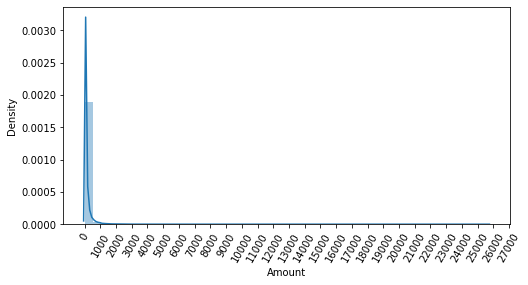

In [9]:
plt.figure(figsize=(8, 4))
plt.xticks(range(0, 30000, 1000), rotation=60)
sns.distplot(card_df['Amount'])

#### amount 피처를 표준 정규 분포형태로 변환 및 LightGBM 수행

In [10]:
# 사이킷런의 StandardScaler를 이용하여 정규분포 형태로 Amount 피처값 변환하는 로직으로 수정. 
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    scaler = StandardScaler()
    amount_n = scaler.fit_transform(df_copy['Amount'].values.reshape(-1, 1))
    # 변환된 Amount를 Amount_Scaled로 피처명 변경후 DataFrame맨 앞 컬럼으로 입력
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    # 기존 Time, Amount 피처 삭제
    df_copy.drop(['Time','Amount'], axis=1, inplace=True)
    return df_copy

In [11]:
# Amount를 정규분포 형태로 변환 후 로지스틱 회귀 및 LightGBM 수행. 
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)


오차 행렬
[[85290     5]
 [   37   111]]
정확도: 0.9995, 정밀도: 0.9569, 재현율: 0.7500,    F1: 0.8409, AUC:0.9779


#### amount 피처를 log 변환 및 LightGBM 수행
* 정규 분포 변환보다 log변환이 재현율 상승이 더 큼

In [12]:
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    # 넘파이의 log1p( )를 이용하여 Amount를 로그 변환 
    amount_n = np.log1p(df_copy['Amount'])
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    df_copy.drop(['Time','Amount'], axis=1, inplace=True)
    return df_copy

In [13]:
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print('LightGBM 예측 성능')
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)


LightGBM 예측 성능
오차 행렬
[[85290     5]
 [   35   113]]
정확도: 0.9995, 정밀도: 0.9576, 재현율: 0.7635,    F1: 0.8496, AUC:0.9796


### 이상치 데이터 제거 후 모델 학습/예측/평가

#### 이상치 제거를 위해 target 값과 상관성이 높은 피처 확인
* v14 피처와 v17피처가 레이블 값과 강한 음의 상관 관계를 보임

<AxesSubplot:>

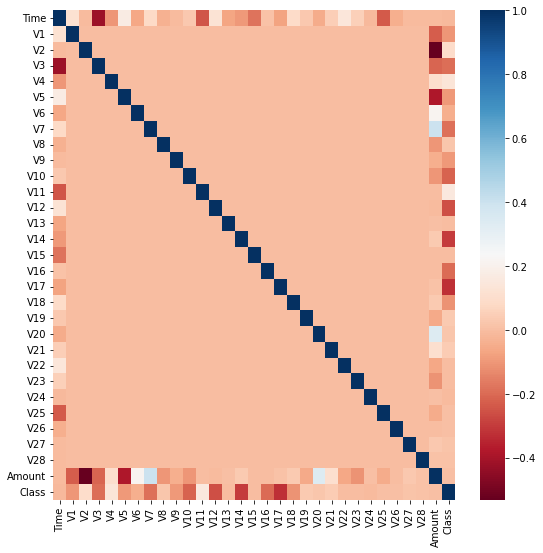

In [14]:
plt.figure(figsize=(9, 9))
corr = card_df.corr()
sns.heatmap(corr, cmap='RdBu')

#### 이상치 검출 함수 구현
* 함수 내에서 넘파이의 percentile()을 이용해 1/4분위 3/4분위를 구하고, 이에 기반해 IQR계산
* 계산된 IQR에 1.5를 곱해 최댓값과 최솟값 지점을 구한뒤, 최댁값보다 크거나 최솟값보다 작은 갑을 이상치로 설정
* 해당 이상치가 있는 DataFrame Index반환

In [15]:
def get_outlier(df=None, column=None, weight=1.5):
    # fraud에 해당하는 column 데이터만 추출, 1/4 분위와 3/4 분위 지점을 np.percentile로 구함. 
    fraud = df[df['Class']==1][column]
    quantile_25 = np.percentile(fraud.values, 25)
    quantile_75 = np.percentile(fraud.values, 75)
    # IQR을 구하고, IQR에 1.5를 곱하여 최대값과 최소값 지점 구함. 
    iqr = quantile_75 - quantile_25
    iqr_weight = iqr * weight
    lowest_val = quantile_25 - iqr_weight
    highest_val = quantile_75 + iqr_weight
    # 최대값 보다 크거나, 최소값 보다 작은 값을 아웃라이어로 설정하고 DataFrame index 반환. 
    outlier_index = fraud[(fraud < lowest_val) | (fraud > highest_val)].index
    return outlier_index
    

In [16]:
outlier_index = get_outlier(df=card_df, column='V14', weight=1.5)
outlier_index2 = get_outlier(df=card_df, column='V17', weight=1.5)

print('v14 이상치 데이터 인덱스:', outlier_index)
print('v17 이상치 데이터 인덱스:', outlier_index2)

v14 이상치 데이터 인덱스: Int64Index([8296, 8615, 9035, 9252], dtype='int64')
v17 이상치 데이터 인덱스: Int64Index([], dtype='int64')


#### 이상치 삭제후 LightGBM 수행
* v17피처는 이상치가 없으므로 v14에 대해서 이상치 제거
* LightGBM의 경우 재현율이 76%에서 82%로 크게 증가

In [17]:
# get_processed_df( )를 로그 변환 후 V14 피처의 이상치 데이터를 삭제하는 로직으로 변경. 
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    amount_n = np.log1p(df_copy['Amount'])
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    df_copy.drop(['Time','Amount'], axis=1, inplace=True)
    # 이상치 데이터 삭제하는 로직 추가
    outlier_index = get_outlier(df=df_copy, column='V14', weight=1.5)
    df_copy.drop(outlier_index, axis=0, inplace=True)
    return df_copy

X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)
print('LightGBM 예측 성능')
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)


LightGBM 예측 성능
오차 행렬
[[85290     5]
 [   25   121]]
정확도: 0.9996, 정밀도: 0.9603, 재현율: 0.8288,    F1: 0.8897, AUC:0.9780


### SMOTE 오버 샘플링 적용 후 모델 학습/예측/평가
* 피처 정규화 및 이상치 제거된 train data를 대상으로 SMOTE 오버 샘플링 수행

In [18]:
smote = SMOTE(random_state=0)
X_train_over, y_train_over = smote.fit_resample(X_train, y_train)
print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트: ', X_train.shape, y_train.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트: ', X_train_over.shape, y_train_over.shape)
print('SMOTE 적용 후 레이블 값 분포: \n', pd.Series(y_train_over).value_counts())

SMOTE 적용 전 학습용 피처/레이블 데이터 세트:  (199362, 29) (199362,)
SMOTE 적용 후 학습용 피처/레이블 데이터 세트:  (398040, 29) (398040,)
SMOTE 적용 후 레이블 값 분포: 
 0    199020
1    199020
Name: Class, dtype: int64


In [19]:
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train_over, ftr_test=X_test,
                  tgt_train=y_train_over, tgt_test=y_test)

오차 행렬
[[85283    12]
 [   22   124]]
정확도: 0.9996, 정밀도: 0.9118, 재현율: 0.8493,    F1: 0.8794, AUC:0.9814


#### ROC AUC를 평가 지표로 하여 하이퍼 파라미터 튜닝
* num_leaves
    * 하나의 트리가 가질수 있는 최대 leaf node 개수
* max_depth
    * 트리의 최대 깊이
* min_child_samples
    * 리프 노드가 되기 위한 최소한의 샘플 수, 클수록 분할을 자제하며 과적합을 조절하기 위해 사용
* subsample
    * 과적합을 제어하기 위해 데이터를 샘플링하는 비율

In [20]:
# 하이퍼 파라미터 테스트의 수행 속도를 향상시키기 위해 n_estimators를 100으로 감소
lgbm_clf = LGBMClassifier(n_estimators=100, boost_from_average=False)

params = {'num_leaves': [32, 64],
          'max_depth':[128, 160],
          'min_child_samples':[60, 100],
          'subsample':[0.8, 1]}


# cv는 3으로 지정 
gridcv = GridSearchCV(lgbm_clf, param_grid=params, cv=3)
gridcv.fit(X_train_over, y_train_over, early_stopping_rounds=30, eval_metric="auc",
           eval_set=[(X_train_over, y_train_over), (X_train_over, y_train_over)])

print('GridSearchCV 최적 파라미터:', gridcv.best_params_)
lgbm_roc_score = roc_auc_score(y_test, gridcv.predict_proba(X_test)[:,1], average='macro')
print('ROC AUC: {0:.4f}'.format(lgbm_roc_score))


[1]	valid_0's auc: 0.988743	valid_0's binary_logloss: 0.60733	valid_1's auc: 0.988743	valid_1's binary_logloss: 0.60733
[2]	valid_0's auc: 0.990574	valid_0's binary_logloss: 0.536879	valid_1's auc: 0.990574	valid_1's binary_logloss: 0.536879
[3]	valid_0's auc: 0.994667	valid_0's binary_logloss: 0.478961	valid_1's auc: 0.994667	valid_1's binary_logloss: 0.478961
[4]	valid_0's auc: 0.995424	valid_0's binary_logloss: 0.429395	valid_1's auc: 0.995424	valid_1's binary_logloss: 0.429395
[5]	valid_0's auc: 0.996415	valid_0's binary_logloss: 0.386357	valid_1's auc: 0.996415	valid_1's binary_logloss: 0.386357
[6]	valid_0's auc: 0.99649	valid_0's binary_logloss: 0.349192	valid_1's auc: 0.99649	valid_1's binary_logloss: 0.349192
[7]	valid_0's auc: 0.996652	valid_0's binary_logloss: 0.316928	valid_1's auc: 0.996652	valid_1's binary_logloss: 0.316928
[8]	valid_0's auc: 0.996751	valid_0's binary_logloss: 0.28843	valid_1's auc: 0.996751	valid_1's binary_logloss: 0.28843
[9]	valid_0's auc: 0.997308	va

[70]	valid_0's auc: 0.999882	valid_0's binary_logloss: 0.00885038	valid_1's auc: 0.999882	valid_1's binary_logloss: 0.00885038
[71]	valid_0's auc: 0.999884	valid_0's binary_logloss: 0.00855787	valid_1's auc: 0.999884	valid_1's binary_logloss: 0.00855787
[72]	valid_0's auc: 0.999884	valid_0's binary_logloss: 0.00826555	valid_1's auc: 0.999884	valid_1's binary_logloss: 0.00826555
[73]	valid_0's auc: 0.999885	valid_0's binary_logloss: 0.00800254	valid_1's auc: 0.999885	valid_1's binary_logloss: 0.00800254
[74]	valid_0's auc: 0.999886	valid_0's binary_logloss: 0.00774332	valid_1's auc: 0.999886	valid_1's binary_logloss: 0.00774332
[75]	valid_0's auc: 0.999889	valid_0's binary_logloss: 0.00753023	valid_1's auc: 0.999889	valid_1's binary_logloss: 0.00753023
[76]	valid_0's auc: 0.999248	valid_0's binary_logloss: 0.0115061	valid_1's auc: 0.999248	valid_1's binary_logloss: 0.0115061
[77]	valid_0's auc: 0.999964	valid_0's binary_logloss: 0.0068521	valid_1's auc: 0.999964	valid_1's binary_logloss

[39]	valid_0's auc: 0.999777	valid_0's binary_logloss: 0.0331063	valid_1's auc: 0.999777	valid_1's binary_logloss: 0.0331063
[40]	valid_0's auc: 0.999788	valid_0's binary_logloss: 0.0312707	valid_1's auc: 0.999788	valid_1's binary_logloss: 0.0312707
[41]	valid_0's auc: 0.999798	valid_0's binary_logloss: 0.0295947	valid_1's auc: 0.999798	valid_1's binary_logloss: 0.0295947
[42]	valid_0's auc: 0.999803	valid_0's binary_logloss: 0.0281586	valid_1's auc: 0.999803	valid_1's binary_logloss: 0.0281586
[43]	valid_0's auc: 0.999809	valid_0's binary_logloss: 0.0267761	valid_1's auc: 0.999809	valid_1's binary_logloss: 0.0267761
[44]	valid_0's auc: 0.999817	valid_0's binary_logloss: 0.0254834	valid_1's auc: 0.999817	valid_1's binary_logloss: 0.0254834
[45]	valid_0's auc: 0.999824	valid_0's binary_logloss: 0.0242242	valid_1's auc: 0.999824	valid_1's binary_logloss: 0.0242242
[46]	valid_0's auc: 0.999834	valid_0's binary_logloss: 0.0230674	valid_1's auc: 0.999834	valid_1's binary_logloss: 0.0230674


[8]	valid_0's auc: 0.997247	valid_0's binary_logloss: 0.287912	valid_1's auc: 0.997247	valid_1's binary_logloss: 0.287912
[9]	valid_0's auc: 0.997386	valid_0's binary_logloss: 0.262974	valid_1's auc: 0.997386	valid_1's binary_logloss: 0.262974
[10]	valid_0's auc: 0.997531	valid_0's binary_logloss: 0.240738	valid_1's auc: 0.997531	valid_1's binary_logloss: 0.240738
[11]	valid_0's auc: 0.997903	valid_0's binary_logloss: 0.220461	valid_1's auc: 0.997903	valid_1's binary_logloss: 0.220461
[12]	valid_0's auc: 0.998044	valid_0's binary_logloss: 0.202434	valid_1's auc: 0.998044	valid_1's binary_logloss: 0.202434
[13]	valid_0's auc: 0.998248	valid_0's binary_logloss: 0.186287	valid_1's auc: 0.998248	valid_1's binary_logloss: 0.186287
[14]	valid_0's auc: 0.998539	valid_0's binary_logloss: 0.171613	valid_1's auc: 0.998539	valid_1's binary_logloss: 0.171613
[15]	valid_0's auc: 0.998783	valid_0's binary_logloss: 0.157759	valid_1's auc: 0.998783	valid_1's binary_logloss: 0.157759
[16]	valid_0's auc

[74]	valid_0's auc: 0.99994	valid_0's binary_logloss: 0.00753959	valid_1's auc: 0.99994	valid_1's binary_logloss: 0.00753959
[75]	valid_0's auc: 0.99994	valid_0's binary_logloss: 0.00729735	valid_1's auc: 0.99994	valid_1's binary_logloss: 0.00729735
[76]	valid_0's auc: 0.999941	valid_0's binary_logloss: 0.00704818	valid_1's auc: 0.999941	valid_1's binary_logloss: 0.00704818
[77]	valid_0's auc: 0.999941	valid_0's binary_logloss: 0.00684227	valid_1's auc: 0.999941	valid_1's binary_logloss: 0.00684227
[78]	valid_0's auc: 0.999941	valid_0's binary_logloss: 0.00662354	valid_1's auc: 0.999941	valid_1's binary_logloss: 0.00662354
[79]	valid_0's auc: 0.999942	valid_0's binary_logloss: 0.0064189	valid_1's auc: 0.999942	valid_1's binary_logloss: 0.0064189
[80]	valid_0's auc: 0.999942	valid_0's binary_logloss: 0.00623666	valid_1's auc: 0.999942	valid_1's binary_logloss: 0.00623666
[81]	valid_0's auc: 0.999942	valid_0's binary_logloss: 0.00604958	valid_1's auc: 0.999942	valid_1's binary_logloss: 0

[40]	valid_0's auc: 0.999783	valid_0's binary_logloss: 0.0308906	valid_1's auc: 0.999783	valid_1's binary_logloss: 0.0308906
[41]	valid_0's auc: 0.999788	valid_0's binary_logloss: 0.0293834	valid_1's auc: 0.999788	valid_1's binary_logloss: 0.0293834
[42]	valid_0's auc: 0.999796	valid_0's binary_logloss: 0.0279279	valid_1's auc: 0.999796	valid_1's binary_logloss: 0.0279279
[43]	valid_0's auc: 0.999823	valid_0's binary_logloss: 0.0262767	valid_1's auc: 0.999823	valid_1's binary_logloss: 0.0262767
[44]	valid_0's auc: 0.99983	valid_0's binary_logloss: 0.0249747	valid_1's auc: 0.99983	valid_1's binary_logloss: 0.0249747
[45]	valid_0's auc: 0.999834	valid_0's binary_logloss: 0.0238583	valid_1's auc: 0.999834	valid_1's binary_logloss: 0.0238583
[46]	valid_0's auc: 0.999837	valid_0's binary_logloss: 0.0227879	valid_1's auc: 0.999837	valid_1's binary_logloss: 0.0227879
[47]	valid_0's auc: 0.99984	valid_0's binary_logloss: 0.021666	valid_1's auc: 0.99984	valid_1's binary_logloss: 0.021666
[48]	v

[8]	valid_0's auc: 0.997069	valid_0's binary_logloss: 0.288165	valid_1's auc: 0.997069	valid_1's binary_logloss: 0.288165
[9]	valid_0's auc: 0.997279	valid_0's binary_logloss: 0.262551	valid_1's auc: 0.997279	valid_1's binary_logloss: 0.262551
[10]	valid_0's auc: 0.99753	valid_0's binary_logloss: 0.239786	valid_1's auc: 0.99753	valid_1's binary_logloss: 0.239786
[11]	valid_0's auc: 0.997921	valid_0's binary_logloss: 0.219829	valid_1's auc: 0.997921	valid_1's binary_logloss: 0.219829
[12]	valid_0's auc: 0.99798	valid_0's binary_logloss: 0.201799	valid_1's auc: 0.99798	valid_1's binary_logloss: 0.201799
[13]	valid_0's auc: 0.99817	valid_0's binary_logloss: 0.185756	valid_1's auc: 0.99817	valid_1's binary_logloss: 0.185756
[14]	valid_0's auc: 0.998304	valid_0's binary_logloss: 0.171409	valid_1's auc: 0.998304	valid_1's binary_logloss: 0.171409
[15]	valid_0's auc: 0.998641	valid_0's binary_logloss: 0.158388	valid_1's auc: 0.998641	valid_1's binary_logloss: 0.158388
[16]	valid_0's auc: 0.99

[77]	valid_0's auc: 0.999898	valid_0's binary_logloss: 0.00708416	valid_1's auc: 0.999898	valid_1's binary_logloss: 0.00708416
[78]	valid_0's auc: 0.999898	valid_0's binary_logloss: 0.006856	valid_1's auc: 0.999898	valid_1's binary_logloss: 0.006856
[79]	valid_0's auc: 0.999899	valid_0's binary_logloss: 0.00662245	valid_1's auc: 0.999899	valid_1's binary_logloss: 0.00662245
[80]	valid_0's auc: 0.999528	valid_0's binary_logloss: 0.00849044	valid_1's auc: 0.999528	valid_1's binary_logloss: 0.00849044
[81]	valid_0's auc: 0.999947	valid_0's binary_logloss: 0.00644151	valid_1's auc: 0.999947	valid_1's binary_logloss: 0.00644151
[82]	valid_0's auc: 0.999948	valid_0's binary_logloss: 0.00618324	valid_1's auc: 0.999948	valid_1's binary_logloss: 0.00618324
[83]	valid_0's auc: 0.999949	valid_0's binary_logloss: 0.00595284	valid_1's auc: 0.999949	valid_1's binary_logloss: 0.00595284
[84]	valid_0's auc: 0.99995	valid_0's binary_logloss: 0.00575416	valid_1's auc: 0.99995	valid_1's binary_logloss: 0

[44]	valid_0's auc: 0.999821	valid_0's binary_logloss: 0.0248164	valid_1's auc: 0.999821	valid_1's binary_logloss: 0.0248164
[45]	valid_0's auc: 0.999827	valid_0's binary_logloss: 0.0236706	valid_1's auc: 0.999827	valid_1's binary_logloss: 0.0236706
[46]	valid_0's auc: 0.999833	valid_0's binary_logloss: 0.0226399	valid_1's auc: 0.999833	valid_1's binary_logloss: 0.0226399
[47]	valid_0's auc: 0.999836	valid_0's binary_logloss: 0.021542	valid_1's auc: 0.999836	valid_1's binary_logloss: 0.021542
[48]	valid_0's auc: 0.999841	valid_0's binary_logloss: 0.0205566	valid_1's auc: 0.999841	valid_1's binary_logloss: 0.0205566
[49]	valid_0's auc: 0.999848	valid_0's binary_logloss: 0.0196768	valid_1's auc: 0.999848	valid_1's binary_logloss: 0.0196768
[50]	valid_0's auc: 0.99985	valid_0's binary_logloss: 0.0188308	valid_1's auc: 0.99985	valid_1's binary_logloss: 0.0188308
[51]	valid_0's auc: 0.999853	valid_0's binary_logloss: 0.0179345	valid_1's auc: 0.999853	valid_1's binary_logloss: 0.0179345
[52]

[13]	valid_0's auc: 0.999316	valid_0's binary_logloss: 0.167113	valid_1's auc: 0.999316	valid_1's binary_logloss: 0.167113
[14]	valid_0's auc: 0.999339	valid_0's binary_logloss: 0.152395	valid_1's auc: 0.999339	valid_1's binary_logloss: 0.152395
[15]	valid_0's auc: 0.999424	valid_0's binary_logloss: 0.139142	valid_1's auc: 0.999424	valid_1's binary_logloss: 0.139142
[16]	valid_0's auc: 0.999449	valid_0's binary_logloss: 0.127222	valid_1's auc: 0.999449	valid_1's binary_logloss: 0.127222
[17]	valid_0's auc: 0.999486	valid_0's binary_logloss: 0.116559	valid_1's auc: 0.999486	valid_1's binary_logloss: 0.116559
[18]	valid_0's auc: 0.999505	valid_0's binary_logloss: 0.106677	valid_1's auc: 0.999505	valid_1's binary_logloss: 0.106677
[19]	valid_0's auc: 0.999528	valid_0's binary_logloss: 0.0976947	valid_1's auc: 0.999528	valid_1's binary_logloss: 0.0976947
[20]	valid_0's auc: 0.999557	valid_0's binary_logloss: 0.089603	valid_1's auc: 0.999557	valid_1's binary_logloss: 0.089603
[21]	valid_0's

[80]	valid_0's auc: 0.999993	valid_0's binary_logloss: 0.00198315	valid_1's auc: 0.999993	valid_1's binary_logloss: 0.00198315
[81]	valid_0's auc: 0.999994	valid_0's binary_logloss: 0.00190037	valid_1's auc: 0.999994	valid_1's binary_logloss: 0.00190037
[82]	valid_0's auc: 0.999997	valid_0's binary_logloss: 0.00180927	valid_1's auc: 0.999997	valid_1's binary_logloss: 0.00180927
[83]	valid_0's auc: 0.999997	valid_0's binary_logloss: 0.0017327	valid_1's auc: 0.999997	valid_1's binary_logloss: 0.0017327
[84]	valid_0's auc: 0.999998	valid_0's binary_logloss: 0.00181421	valid_1's auc: 0.999998	valid_1's binary_logloss: 0.00181421
[85]	valid_0's auc: 0.999998	valid_0's binary_logloss: 0.00171645	valid_1's auc: 0.999998	valid_1's binary_logloss: 0.00171645
[86]	valid_0's auc: 0.999998	valid_0's binary_logloss: 0.0016302	valid_1's auc: 0.999998	valid_1's binary_logloss: 0.0016302
[87]	valid_0's auc: 0.999998	valid_0's binary_logloss: 0.00155263	valid_1's auc: 0.999998	valid_1's binary_logloss:

[47]	valid_0's auc: 0.999894	valid_0's binary_logloss: 0.0119548	valid_1's auc: 0.999894	valid_1's binary_logloss: 0.0119548
[48]	valid_0's auc: 0.999898	valid_0's binary_logloss: 0.0111798	valid_1's auc: 0.999898	valid_1's binary_logloss: 0.0111798
[49]	valid_0's auc: 0.999901	valid_0's binary_logloss: 0.0104812	valid_1's auc: 0.999901	valid_1's binary_logloss: 0.0104812
[50]	valid_0's auc: 0.999901	valid_0's binary_logloss: 0.00986422	valid_1's auc: 0.999901	valid_1's binary_logloss: 0.00986422
[51]	valid_0's auc: 0.999903	valid_0's binary_logloss: 0.00925226	valid_1's auc: 0.999903	valid_1's binary_logloss: 0.00925226
[52]	valid_0's auc: 0.999903	valid_0's binary_logloss: 0.00870139	valid_1's auc: 0.999903	valid_1's binary_logloss: 0.00870139
[53]	valid_0's auc: 0.999903	valid_0's binary_logloss: 0.00821423	valid_1's auc: 0.999903	valid_1's binary_logloss: 0.00821423
[54]	valid_0's auc: 0.999903	valid_0's binary_logloss: 0.00776135	valid_1's auc: 0.999903	valid_1's binary_logloss: 0

[17]	valid_0's auc: 0.999686	valid_0's binary_logloss: 0.116041	valid_1's auc: 0.999686	valid_1's binary_logloss: 0.116041
[18]	valid_0's auc: 0.999704	valid_0's binary_logloss: 0.106273	valid_1's auc: 0.999704	valid_1's binary_logloss: 0.106273
[19]	valid_0's auc: 0.99972	valid_0's binary_logloss: 0.0973988	valid_1's auc: 0.99972	valid_1's binary_logloss: 0.0973988
[20]	valid_0's auc: 0.999735	valid_0's binary_logloss: 0.0894149	valid_1's auc: 0.999735	valid_1's binary_logloss: 0.0894149
[21]	valid_0's auc: 0.99975	valid_0's binary_logloss: 0.0820368	valid_1's auc: 0.99975	valid_1's binary_logloss: 0.0820368
[22]	valid_0's auc: 0.999757	valid_0's binary_logloss: 0.0754439	valid_1's auc: 0.999757	valid_1's binary_logloss: 0.0754439
[23]	valid_0's auc: 0.999769	valid_0's binary_logloss: 0.0694678	valid_1's auc: 0.999769	valid_1's binary_logloss: 0.0694678
[24]	valid_0's auc: 0.999779	valid_0's binary_logloss: 0.0640174	valid_1's auc: 0.999779	valid_1's binary_logloss: 0.0640174
[25]	val

[85]	valid_0's auc: 0.999985	valid_0's binary_logloss: 0.00155411	valid_1's auc: 0.999985	valid_1's binary_logloss: 0.00155411
[86]	valid_0's auc: 0.999986	valid_0's binary_logloss: 0.00149123	valid_1's auc: 0.999986	valid_1's binary_logloss: 0.00149123
[87]	valid_0's auc: 0.999986	valid_0's binary_logloss: 0.00143407	valid_1's auc: 0.999986	valid_1's binary_logloss: 0.00143407
[88]	valid_0's auc: 0.999986	valid_0's binary_logloss: 0.00138017	valid_1's auc: 0.999986	valid_1's binary_logloss: 0.00138017
[89]	valid_0's auc: 0.999985	valid_0's binary_logloss: 0.00132658	valid_1's auc: 0.999985	valid_1's binary_logloss: 0.00132658
[90]	valid_0's auc: 0.999986	valid_0's binary_logloss: 0.00127811	valid_1's auc: 0.999986	valid_1's binary_logloss: 0.00127811
[91]	valid_0's auc: 0.999986	valid_0's binary_logloss: 0.00122905	valid_1's auc: 0.999986	valid_1's binary_logloss: 0.00122905
[92]	valid_0's auc: 0.999987	valid_0's binary_logloss: 0.00118593	valid_1's auc: 0.999987	valid_1's binary_logl

[52]	valid_0's auc: 0.999895	valid_0's binary_logloss: 0.00870301	valid_1's auc: 0.999895	valid_1's binary_logloss: 0.00870301
[53]	valid_0's auc: 0.999898	valid_0's binary_logloss: 0.00820663	valid_1's auc: 0.999898	valid_1's binary_logloss: 0.00820663
[54]	valid_0's auc: 0.999898	valid_0's binary_logloss: 0.00773666	valid_1's auc: 0.999898	valid_1's binary_logloss: 0.00773666
[55]	valid_0's auc: 0.999898	valid_0's binary_logloss: 0.00730306	valid_1's auc: 0.999898	valid_1's binary_logloss: 0.00730306
[56]	valid_0's auc: 0.9999	valid_0's binary_logloss: 0.0069079	valid_1's auc: 0.9999	valid_1's binary_logloss: 0.0069079
[57]	valid_0's auc: 0.9999	valid_0's binary_logloss: 0.0065379	valid_1's auc: 0.9999	valid_1's binary_logloss: 0.0065379
[58]	valid_0's auc: 0.999901	valid_0's binary_logloss: 0.00618524	valid_1's auc: 0.999901	valid_1's binary_logloss: 0.00618524
[59]	valid_0's auc: 0.999966	valid_0's binary_logloss: 0.00599749	valid_1's auc: 0.999966	valid_1's binary_logloss: 0.00599

[22]	valid_0's auc: 0.999678	valid_0's binary_logloss: 0.0757017	valid_1's auc: 0.999678	valid_1's binary_logloss: 0.0757017
[23]	valid_0's auc: 0.999688	valid_0's binary_logloss: 0.0697224	valid_1's auc: 0.999688	valid_1's binary_logloss: 0.0697224
[24]	valid_0's auc: 0.999695	valid_0's binary_logloss: 0.0642285	valid_1's auc: 0.999695	valid_1's binary_logloss: 0.0642285
[25]	valid_0's auc: 0.999703	valid_0's binary_logloss: 0.059296	valid_1's auc: 0.999703	valid_1's binary_logloss: 0.059296
[26]	valid_0's auc: 0.999711	valid_0's binary_logloss: 0.0548326	valid_1's auc: 0.999711	valid_1's binary_logloss: 0.0548326
[27]	valid_0's auc: 0.999722	valid_0's binary_logloss: 0.0506715	valid_1's auc: 0.999722	valid_1's binary_logloss: 0.0506715
[28]	valid_0's auc: 0.999794	valid_0's binary_logloss: 0.0467859	valid_1's auc: 0.999794	valid_1's binary_logloss: 0.0467859
[29]	valid_0's auc: 0.99981	valid_0's binary_logloss: 0.0431705	valid_1's auc: 0.99981	valid_1's binary_logloss: 0.0431705
[30]

[88]	valid_0's auc: 0.999993	valid_0's binary_logloss: 0.00133886	valid_1's auc: 0.999993	valid_1's binary_logloss: 0.00133886
[89]	valid_0's auc: 0.999993	valid_0's binary_logloss: 0.00128609	valid_1's auc: 0.999993	valid_1's binary_logloss: 0.00128609
[90]	valid_0's auc: 0.999993	valid_0's binary_logloss: 0.00124069	valid_1's auc: 0.999993	valid_1's binary_logloss: 0.00124069
[91]	valid_0's auc: 0.999993	valid_0's binary_logloss: 0.00119003	valid_1's auc: 0.999993	valid_1's binary_logloss: 0.00119003
[92]	valid_0's auc: 0.999993	valid_0's binary_logloss: 0.00114367	valid_1's auc: 0.999993	valid_1's binary_logloss: 0.00114367
[93]	valid_0's auc: 0.999993	valid_0's binary_logloss: 0.0011056	valid_1's auc: 0.999993	valid_1's binary_logloss: 0.0011056
[94]	valid_0's auc: 0.999994	valid_0's binary_logloss: 0.00106339	valid_1's auc: 0.999994	valid_1's binary_logloss: 0.00106339
[95]	valid_0's auc: 0.999994	valid_0's binary_logloss: 0.00102563	valid_1's auc: 0.999994	valid_1's binary_loglos

[57]	valid_0's auc: 0.999967	valid_0's binary_logloss: 0.00654185	valid_1's auc: 0.999967	valid_1's binary_logloss: 0.00654185
[58]	valid_0's auc: 0.999969	valid_0's binary_logloss: 0.00614859	valid_1's auc: 0.999969	valid_1's binary_logloss: 0.00614859
[59]	valid_0's auc: 0.999971	valid_0's binary_logloss: 0.00576998	valid_1's auc: 0.999971	valid_1's binary_logloss: 0.00576998
[60]	valid_0's auc: 0.999971	valid_0's binary_logloss: 0.005431	valid_1's auc: 0.999971	valid_1's binary_logloss: 0.005431
[61]	valid_0's auc: 0.999971	valid_0's binary_logloss: 0.0051198	valid_1's auc: 0.999971	valid_1's binary_logloss: 0.0051198
[62]	valid_0's auc: 0.999972	valid_0's binary_logloss: 0.004834	valid_1's auc: 0.999972	valid_1's binary_logloss: 0.004834
[63]	valid_0's auc: 0.999972	valid_0's binary_logloss: 0.00457286	valid_1's auc: 0.999972	valid_1's binary_logloss: 0.00457286
[64]	valid_0's auc: 0.999972	valid_0's binary_logloss: 0.00431981	valid_1's auc: 0.999972	valid_1's binary_logloss: 0.004

[25]	valid_0's auc: 0.99952	valid_0's binary_logloss: 0.0754864	valid_1's auc: 0.99952	valid_1's binary_logloss: 0.0754864
[26]	valid_0's auc: 0.999548	valid_0's binary_logloss: 0.0706338	valid_1's auc: 0.999548	valid_1's binary_logloss: 0.0706338
[27]	valid_0's auc: 0.999571	valid_0's binary_logloss: 0.0663453	valid_1's auc: 0.999571	valid_1's binary_logloss: 0.0663453
[28]	valid_0's auc: 0.999597	valid_0's binary_logloss: 0.0622693	valid_1's auc: 0.999597	valid_1's binary_logloss: 0.0622693
[29]	valid_0's auc: 0.999622	valid_0's binary_logloss: 0.0584354	valid_1's auc: 0.999622	valid_1's binary_logloss: 0.0584354
[30]	valid_0's auc: 0.999646	valid_0's binary_logloss: 0.054772	valid_1's auc: 0.999646	valid_1's binary_logloss: 0.054772
[31]	valid_0's auc: 0.999669	valid_0's binary_logloss: 0.0514649	valid_1's auc: 0.999669	valid_1's binary_logloss: 0.0514649
[32]	valid_0's auc: 0.999682	valid_0's binary_logloss: 0.0484633	valid_1's auc: 0.999682	valid_1's binary_logloss: 0.0484633
[33]

[94]	valid_0's auc: 0.999988	valid_0's binary_logloss: 0.00428729	valid_1's auc: 0.999988	valid_1's binary_logloss: 0.00428729
[95]	valid_0's auc: 0.999989	valid_0's binary_logloss: 0.00415294	valid_1's auc: 0.999989	valid_1's binary_logloss: 0.00415294
[96]	valid_0's auc: 0.999989	valid_0's binary_logloss: 0.0040348	valid_1's auc: 0.999989	valid_1's binary_logloss: 0.0040348
[97]	valid_0's auc: 0.999989	valid_0's binary_logloss: 0.00391432	valid_1's auc: 0.999989	valid_1's binary_logloss: 0.00391432
[98]	valid_0's auc: 0.99999	valid_0's binary_logloss: 0.00379823	valid_1's auc: 0.99999	valid_1's binary_logloss: 0.00379823
[99]	valid_0's auc: 0.99999	valid_0's binary_logloss: 0.0037112	valid_1's auc: 0.99999	valid_1's binary_logloss: 0.0037112
[100]	valid_0's auc: 0.99999	valid_0's binary_logloss: 0.00359292	valid_1's auc: 0.99999	valid_1's binary_logloss: 0.00359292
[1]	valid_0's auc: 0.984952	valid_0's binary_logloss: 0.608374	valid_1's auc: 0.984952	valid_1's binary_logloss: 0.60837

[62]	valid_0's auc: 0.999877	valid_0's binary_logloss: 0.0117836	valid_1's auc: 0.999877	valid_1's binary_logloss: 0.0117836
[63]	valid_0's auc: 0.999879	valid_0's binary_logloss: 0.0113806	valid_1's auc: 0.999879	valid_1's binary_logloss: 0.0113806
[64]	valid_0's auc: 0.99988	valid_0's binary_logloss: 0.0109627	valid_1's auc: 0.99988	valid_1's binary_logloss: 0.0109627
[65]	valid_0's auc: 0.999881	valid_0's binary_logloss: 0.0106169	valid_1's auc: 0.999881	valid_1's binary_logloss: 0.0106169
[66]	valid_0's auc: 0.999882	valid_0's binary_logloss: 0.0102593	valid_1's auc: 0.999882	valid_1's binary_logloss: 0.0102593
[67]	valid_0's auc: 0.999883	valid_0's binary_logloss: 0.00992088	valid_1's auc: 0.999883	valid_1's binary_logloss: 0.00992088
[68]	valid_0's auc: 0.999884	valid_0's binary_logloss: 0.00958988	valid_1's auc: 0.999884	valid_1's binary_logloss: 0.00958988
[69]	valid_0's auc: 0.999885	valid_0's binary_logloss: 0.00925631	valid_1's auc: 0.999885	valid_1's binary_logloss: 0.00925

[30]	valid_0's auc: 0.99967	valid_0's binary_logloss: 0.0537186	valid_1's auc: 0.99967	valid_1's binary_logloss: 0.0537186
[31]	valid_0's auc: 0.999688	valid_0's binary_logloss: 0.0505119	valid_1's auc: 0.999688	valid_1's binary_logloss: 0.0505119
[32]	valid_0's auc: 0.999699	valid_0's binary_logloss: 0.0475507	valid_1's auc: 0.999699	valid_1's binary_logloss: 0.0475507
[33]	valid_0's auc: 0.999716	valid_0's binary_logloss: 0.0449018	valid_1's auc: 0.999716	valid_1's binary_logloss: 0.0449018
[34]	valid_0's auc: 0.999729	valid_0's binary_logloss: 0.0423823	valid_1's auc: 0.999729	valid_1's binary_logloss: 0.0423823
[35]	valid_0's auc: 0.99974	valid_0's binary_logloss: 0.0401829	valid_1's auc: 0.99974	valid_1's binary_logloss: 0.0401829
[36]	valid_0's auc: 0.999754	valid_0's binary_logloss: 0.0379684	valid_1's auc: 0.999754	valid_1's binary_logloss: 0.0379684
[37]	valid_0's auc: 0.99976	valid_0's binary_logloss: 0.0361022	valid_1's auc: 0.99976	valid_1's binary_logloss: 0.0361022
[38]	v

[99]	valid_0's auc: 0.999981	valid_0's binary_logloss: 0.00377725	valid_1's auc: 0.999981	valid_1's binary_logloss: 0.00377725
[100]	valid_0's auc: 0.999982	valid_0's binary_logloss: 0.00365723	valid_1's auc: 0.999982	valid_1's binary_logloss: 0.00365723
[1]	valid_0's auc: 0.988743	valid_0's binary_logloss: 0.60733	valid_1's auc: 0.988743	valid_1's binary_logloss: 0.60733
[2]	valid_0's auc: 0.990574	valid_0's binary_logloss: 0.536879	valid_1's auc: 0.990574	valid_1's binary_logloss: 0.536879
[3]	valid_0's auc: 0.994667	valid_0's binary_logloss: 0.478961	valid_1's auc: 0.994667	valid_1's binary_logloss: 0.478961
[4]	valid_0's auc: 0.995424	valid_0's binary_logloss: 0.429395	valid_1's auc: 0.995424	valid_1's binary_logloss: 0.429395
[5]	valid_0's auc: 0.996415	valid_0's binary_logloss: 0.386357	valid_1's auc: 0.996415	valid_1's binary_logloss: 0.386357
[6]	valid_0's auc: 0.99649	valid_0's binary_logloss: 0.349192	valid_1's auc: 0.99649	valid_1's binary_logloss: 0.349192
[7]	valid_0's auc

[66]	valid_0's auc: 0.999877	valid_0's binary_logloss: 0.0100521	valid_1's auc: 0.999877	valid_1's binary_logloss: 0.0100521
[67]	valid_0's auc: 0.999878	valid_0's binary_logloss: 0.00970774	valid_1's auc: 0.999878	valid_1's binary_logloss: 0.00970774
[68]	valid_0's auc: 0.999879	valid_0's binary_logloss: 0.0093771	valid_1's auc: 0.999879	valid_1's binary_logloss: 0.0093771
[69]	valid_0's auc: 0.99988	valid_0's binary_logloss: 0.0090167	valid_1's auc: 0.99988	valid_1's binary_logloss: 0.0090167
[70]	valid_0's auc: 0.999881	valid_0's binary_logloss: 0.00875197	valid_1's auc: 0.999881	valid_1's binary_logloss: 0.00875197
[71]	valid_0's auc: 0.999882	valid_0's binary_logloss: 0.00849321	valid_1's auc: 0.999882	valid_1's binary_logloss: 0.00849321
[72]	valid_0's auc: 0.999883	valid_0's binary_logloss: 0.00826051	valid_1's auc: 0.999883	valid_1's binary_logloss: 0.00826051
[73]	valid_0's auc: 0.999884	valid_0's binary_logloss: 0.00798514	valid_1's auc: 0.999884	valid_1's binary_logloss: 0.0

[35]	valid_0's auc: 0.999725	valid_0's binary_logloss: 0.041332	valid_1's auc: 0.999725	valid_1's binary_logloss: 0.041332
[36]	valid_0's auc: 0.99974	valid_0's binary_logloss: 0.0391244	valid_1's auc: 0.99974	valid_1's binary_logloss: 0.0391244
[37]	valid_0's auc: 0.999761	valid_0's binary_logloss: 0.0368785	valid_1's auc: 0.999761	valid_1's binary_logloss: 0.0368785
[38]	valid_0's auc: 0.999772	valid_0's binary_logloss: 0.0348822	valid_1's auc: 0.999772	valid_1's binary_logloss: 0.0348822
[39]	valid_0's auc: 0.999778	valid_0's binary_logloss: 0.0331219	valid_1's auc: 0.999778	valid_1's binary_logloss: 0.0331219
[40]	valid_0's auc: 0.99979	valid_0's binary_logloss: 0.0313015	valid_1's auc: 0.99979	valid_1's binary_logloss: 0.0313015
[41]	valid_0's auc: 0.999797	valid_0's binary_logloss: 0.0297429	valid_1's auc: 0.999797	valid_1's binary_logloss: 0.0297429
[42]	valid_0's auc: 0.999804	valid_0's binary_logloss: 0.0282091	valid_1's auc: 0.999804	valid_1's binary_logloss: 0.0282091
[43]	v

[1]	valid_0's auc: 0.988535	valid_0's binary_logloss: 0.607563	valid_1's auc: 0.988535	valid_1's binary_logloss: 0.607563
[2]	valid_0's auc: 0.994122	valid_0's binary_logloss: 0.538322	valid_1's auc: 0.994122	valid_1's binary_logloss: 0.538322
[3]	valid_0's auc: 0.99569	valid_0's binary_logloss: 0.479807	valid_1's auc: 0.99569	valid_1's binary_logloss: 0.479807
[4]	valid_0's auc: 0.996208	valid_0's binary_logloss: 0.429374	valid_1's auc: 0.996208	valid_1's binary_logloss: 0.429374
[5]	valid_0's auc: 0.996477	valid_0's binary_logloss: 0.386017	valid_1's auc: 0.996477	valid_1's binary_logloss: 0.386017
[6]	valid_0's auc: 0.996687	valid_0's binary_logloss: 0.349042	valid_1's auc: 0.996687	valid_1's binary_logloss: 0.349042
[7]	valid_0's auc: 0.997057	valid_0's binary_logloss: 0.317127	valid_1's auc: 0.997057	valid_1's binary_logloss: 0.317127
[8]	valid_0's auc: 0.997247	valid_0's binary_logloss: 0.287912	valid_1's auc: 0.997247	valid_1's binary_logloss: 0.287912
[9]	valid_0's auc: 0.99738

[71]	valid_0's auc: 0.999949	valid_0's binary_logloss: 0.00926004	valid_1's auc: 0.999949	valid_1's binary_logloss: 0.00926004
[72]	valid_0's auc: 0.999954	valid_0's binary_logloss: 0.00875275	valid_1's auc: 0.999954	valid_1's binary_logloss: 0.00875275
[73]	valid_0's auc: 0.999957	valid_0's binary_logloss: 0.00836883	valid_1's auc: 0.999957	valid_1's binary_logloss: 0.00836883
[74]	valid_0's auc: 0.999958	valid_0's binary_logloss: 0.00802727	valid_1's auc: 0.999958	valid_1's binary_logloss: 0.00802727
[75]	valid_0's auc: 0.999959	valid_0's binary_logloss: 0.00771888	valid_1's auc: 0.999959	valid_1's binary_logloss: 0.00771888
[76]	valid_0's auc: 0.999961	valid_0's binary_logloss: 0.00741872	valid_1's auc: 0.999961	valid_1's binary_logloss: 0.00741872
[77]	valid_0's auc: 0.999965	valid_0's binary_logloss: 0.00714406	valid_1's auc: 0.999965	valid_1's binary_logloss: 0.00714406
[78]	valid_0's auc: 0.999966	valid_0's binary_logloss: 0.00686858	valid_1's auc: 0.999966	valid_1's binary_logl

[38]	valid_0's auc: 0.999877	valid_0's binary_logloss: 0.0218411	valid_1's auc: 0.999877	valid_1's binary_logloss: 0.0218411
[39]	valid_0's auc: 0.999881	valid_0's binary_logloss: 0.020375	valid_1's auc: 0.999881	valid_1's binary_logloss: 0.020375
[40]	valid_0's auc: 0.999883	valid_0's binary_logloss: 0.0190293	valid_1's auc: 0.999883	valid_1's binary_logloss: 0.0190293
[41]	valid_0's auc: 0.999885	valid_0's binary_logloss: 0.0177218	valid_1's auc: 0.999885	valid_1's binary_logloss: 0.0177218
[42]	valid_0's auc: 0.99989	valid_0's binary_logloss: 0.016495	valid_1's auc: 0.99989	valid_1's binary_logloss: 0.016495
[43]	valid_0's auc: 0.999892	valid_0's binary_logloss: 0.0153709	valid_1's auc: 0.999892	valid_1's binary_logloss: 0.0153709
[44]	valid_0's auc: 0.999894	valid_0's binary_logloss: 0.0143414	valid_1's auc: 0.999894	valid_1's binary_logloss: 0.0143414
[45]	valid_0's auc: 0.999894	valid_0's binary_logloss: 0.0134052	valid_1's auc: 0.999894	valid_1's binary_logloss: 0.0134052
[46]	v

[7]	valid_0's auc: 0.998974	valid_0's binary_logloss: 0.302259	valid_1's auc: 0.998974	valid_1's binary_logloss: 0.302259
[8]	valid_0's auc: 0.999106	valid_0's binary_logloss: 0.272586	valid_1's auc: 0.999106	valid_1's binary_logloss: 0.272586
[9]	valid_0's auc: 0.999227	valid_0's binary_logloss: 0.246275	valid_1's auc: 0.999227	valid_1's binary_logloss: 0.246275
[10]	valid_0's auc: 0.999315	valid_0's binary_logloss: 0.222878	valid_1's auc: 0.999315	valid_1's binary_logloss: 0.222878
[11]	valid_0's auc: 0.999391	valid_0's binary_logloss: 0.202324	valid_1's auc: 0.999391	valid_1's binary_logloss: 0.202324
[12]	valid_0's auc: 0.999461	valid_0's binary_logloss: 0.183978	valid_1's auc: 0.999461	valid_1's binary_logloss: 0.183978
[13]	valid_0's auc: 0.999499	valid_0's binary_logloss: 0.167426	valid_1's auc: 0.999499	valid_1's binary_logloss: 0.167426
[14]	valid_0's auc: 0.999531	valid_0's binary_logloss: 0.152613	valid_1's auc: 0.999531	valid_1's binary_logloss: 0.152613
[15]	valid_0's auc:

[74]	valid_0's auc: 0.999982	valid_0's binary_logloss: 0.00259562	valid_1's auc: 0.999982	valid_1's binary_logloss: 0.00259562
[75]	valid_0's auc: 0.999983	valid_0's binary_logloss: 0.00246655	valid_1's auc: 0.999983	valid_1's binary_logloss: 0.00246655
[76]	valid_0's auc: 0.999983	valid_0's binary_logloss: 0.00234785	valid_1's auc: 0.999983	valid_1's binary_logloss: 0.00234785
[77]	valid_0's auc: 0.999988	valid_0's binary_logloss: 0.00222477	valid_1's auc: 0.999988	valid_1's binary_logloss: 0.00222477
[78]	valid_0's auc: 0.99999	valid_0's binary_logloss: 0.00211634	valid_1's auc: 0.99999	valid_1's binary_logloss: 0.00211634
[79]	valid_0's auc: 0.999991	valid_0's binary_logloss: 0.00201164	valid_1's auc: 0.999991	valid_1's binary_logloss: 0.00201164
[80]	valid_0's auc: 0.999991	valid_0's binary_logloss: 0.00191776	valid_1's auc: 0.999991	valid_1's binary_logloss: 0.00191776
[81]	valid_0's auc: 0.999991	valid_0's binary_logloss: 0.00183311	valid_1's auc: 0.999991	valid_1's binary_loglos

[40]	valid_0's auc: 0.999879	valid_0's binary_logloss: 0.0190315	valid_1's auc: 0.999879	valid_1's binary_logloss: 0.0190315
[41]	valid_0's auc: 0.99988	valid_0's binary_logloss: 0.0178353	valid_1's auc: 0.99988	valid_1's binary_logloss: 0.0178353
[42]	valid_0's auc: 0.999881	valid_0's binary_logloss: 0.0167351	valid_1's auc: 0.999881	valid_1's binary_logloss: 0.0167351
[43]	valid_0's auc: 0.999886	valid_0's binary_logloss: 0.0156176	valid_1's auc: 0.999886	valid_1's binary_logloss: 0.0156176
[44]	valid_0's auc: 0.999889	valid_0's binary_logloss: 0.0145899	valid_1's auc: 0.999889	valid_1's binary_logloss: 0.0145899
[45]	valid_0's auc: 0.99989	valid_0's binary_logloss: 0.0136617	valid_1's auc: 0.99989	valid_1's binary_logloss: 0.0136617
[46]	valid_0's auc: 0.999891	valid_0's binary_logloss: 0.0127937	valid_1's auc: 0.999891	valid_1's binary_logloss: 0.0127937
[47]	valid_0's auc: 0.999892	valid_0's binary_logloss: 0.0119948	valid_1's auc: 0.999892	valid_1's binary_logloss: 0.0119948
[48]

[7]	valid_0's auc: 0.998757	valid_0's binary_logloss: 0.301842	valid_1's auc: 0.998757	valid_1's binary_logloss: 0.301842
[8]	valid_0's auc: 0.998917	valid_0's binary_logloss: 0.272618	valid_1's auc: 0.998917	valid_1's binary_logloss: 0.272618
[9]	valid_0's auc: 0.998997	valid_0's binary_logloss: 0.246384	valid_1's auc: 0.998997	valid_1's binary_logloss: 0.246384
[10]	valid_0's auc: 0.99908	valid_0's binary_logloss: 0.222966	valid_1's auc: 0.99908	valid_1's binary_logloss: 0.222966
[11]	valid_0's auc: 0.999095	valid_0's binary_logloss: 0.202698	valid_1's auc: 0.999095	valid_1's binary_logloss: 0.202698
[12]	valid_0's auc: 0.999249	valid_0's binary_logloss: 0.183976	valid_1's auc: 0.999249	valid_1's binary_logloss: 0.183976
[13]	valid_0's auc: 0.999323	valid_0's binary_logloss: 0.167555	valid_1's auc: 0.999323	valid_1's binary_logloss: 0.167555
[14]	valid_0's auc: 0.999389	valid_0's binary_logloss: 0.152776	valid_1's auc: 0.999389	valid_1's binary_logloss: 0.152776
[15]	valid_0's auc: 0

[74]	valid_0's auc: 0.999992	valid_0's binary_logloss: 0.00261602	valid_1's auc: 0.999992	valid_1's binary_logloss: 0.00261602
[75]	valid_0's auc: 0.999993	valid_0's binary_logloss: 0.00249098	valid_1's auc: 0.999993	valid_1's binary_logloss: 0.00249098
[76]	valid_0's auc: 0.999995	valid_0's binary_logloss: 0.00236294	valid_1's auc: 0.999995	valid_1's binary_logloss: 0.00236294
[77]	valid_0's auc: 0.999995	valid_0's binary_logloss: 0.00225249	valid_1's auc: 0.999995	valid_1's binary_logloss: 0.00225249
[78]	valid_0's auc: 0.999995	valid_0's binary_logloss: 0.00214812	valid_1's auc: 0.999995	valid_1's binary_logloss: 0.00214812
[79]	valid_0's auc: 0.999995	valid_0's binary_logloss: 0.00204863	valid_1's auc: 0.999995	valid_1's binary_logloss: 0.00204863
[80]	valid_0's auc: 0.999995	valid_0's binary_logloss: 0.00195983	valid_1's auc: 0.999995	valid_1's binary_logloss: 0.00195983
[81]	valid_0's auc: 0.999995	valid_0's binary_logloss: 0.00187496	valid_1's auc: 0.999995	valid_1's binary_logl

[42]	valid_0's auc: 0.999888	valid_0's binary_logloss: 0.0167844	valid_1's auc: 0.999888	valid_1's binary_logloss: 0.0167844
[43]	valid_0's auc: 0.99989	valid_0's binary_logloss: 0.0156772	valid_1's auc: 0.99989	valid_1's binary_logloss: 0.0156772
[44]	valid_0's auc: 0.999891	valid_0's binary_logloss: 0.0146987	valid_1's auc: 0.999891	valid_1's binary_logloss: 0.0146987
[45]	valid_0's auc: 0.999892	valid_0's binary_logloss: 0.0136988	valid_1's auc: 0.999892	valid_1's binary_logloss: 0.0136988
[46]	valid_0's auc: 0.999893	valid_0's binary_logloss: 0.0128224	valid_1's auc: 0.999893	valid_1's binary_logloss: 0.0128224
[47]	valid_0's auc: 0.999895	valid_0's binary_logloss: 0.0120048	valid_1's auc: 0.999895	valid_1's binary_logloss: 0.0120048
[48]	valid_0's auc: 0.999899	valid_0's binary_logloss: 0.0112377	valid_1's auc: 0.999899	valid_1's binary_logloss: 0.0112377
[49]	valid_0's auc: 0.999901	valid_0's binary_logloss: 0.0105478	valid_1's auc: 0.999901	valid_1's binary_logloss: 0.0105478
[5

[7]	valid_0's auc: 0.999186	valid_0's binary_logloss: 0.301782	valid_1's auc: 0.999186	valid_1's binary_logloss: 0.301782
[8]	valid_0's auc: 0.999246	valid_0's binary_logloss: 0.272022	valid_1's auc: 0.999246	valid_1's binary_logloss: 0.272022
[9]	valid_0's auc: 0.999326	valid_0's binary_logloss: 0.245546	valid_1's auc: 0.999326	valid_1's binary_logloss: 0.245546
[10]	valid_0's auc: 0.999382	valid_0's binary_logloss: 0.222445	valid_1's auc: 0.999382	valid_1's binary_logloss: 0.222445
[11]	valid_0's auc: 0.999503	valid_0's binary_logloss: 0.201546	valid_1's auc: 0.999503	valid_1's binary_logloss: 0.201546
[12]	valid_0's auc: 0.999571	valid_0's binary_logloss: 0.183038	valid_1's auc: 0.999571	valid_1's binary_logloss: 0.183038
[13]	valid_0's auc: 0.999594	valid_0's binary_logloss: 0.166588	valid_1's auc: 0.999594	valid_1's binary_logloss: 0.166588
[14]	valid_0's auc: 0.999612	valid_0's binary_logloss: 0.151953	valid_1's auc: 0.999612	valid_1's binary_logloss: 0.151953
[15]	valid_0's auc:

[76]	valid_0's auc: 0.999986	valid_0's binary_logloss: 0.00233873	valid_1's auc: 0.999986	valid_1's binary_logloss: 0.00233873
[77]	valid_0's auc: 0.999986	valid_0's binary_logloss: 0.00223102	valid_1's auc: 0.999986	valid_1's binary_logloss: 0.00223102
[78]	valid_0's auc: 0.999986	valid_0's binary_logloss: 0.00213587	valid_1's auc: 0.999986	valid_1's binary_logloss: 0.00213587
[79]	valid_0's auc: 0.999987	valid_0's binary_logloss: 0.00203574	valid_1's auc: 0.999987	valid_1's binary_logloss: 0.00203574
[80]	valid_0's auc: 0.999988	valid_0's binary_logloss: 0.00193699	valid_1's auc: 0.999988	valid_1's binary_logloss: 0.00193699
[81]	valid_0's auc: 0.999988	valid_0's binary_logloss: 0.00185403	valid_1's auc: 0.999988	valid_1's binary_logloss: 0.00185403
[82]	valid_0's auc: 0.999988	valid_0's binary_logloss: 0.00178203	valid_1's auc: 0.999988	valid_1's binary_logloss: 0.00178203
[83]	valid_0's auc: 0.999988	valid_0's binary_logloss: 0.00171117	valid_1's auc: 0.999988	valid_1's binary_logl

[45]	valid_0's auc: 0.999834	valid_0's binary_logloss: 0.0238583	valid_1's auc: 0.999834	valid_1's binary_logloss: 0.0238583
[46]	valid_0's auc: 0.999837	valid_0's binary_logloss: 0.0227879	valid_1's auc: 0.999837	valid_1's binary_logloss: 0.0227879
[47]	valid_0's auc: 0.99984	valid_0's binary_logloss: 0.021666	valid_1's auc: 0.99984	valid_1's binary_logloss: 0.021666
[48]	valid_0's auc: 0.999846	valid_0's binary_logloss: 0.0206949	valid_1's auc: 0.999846	valid_1's binary_logloss: 0.0206949
[49]	valid_0's auc: 0.999848	valid_0's binary_logloss: 0.0197509	valid_1's auc: 0.999848	valid_1's binary_logloss: 0.0197509
[50]	valid_0's auc: 0.999851	valid_0's binary_logloss: 0.0189358	valid_1's auc: 0.999851	valid_1's binary_logloss: 0.0189358
[51]	valid_0's auc: 0.999853	valid_0's binary_logloss: 0.0181006	valid_1's auc: 0.999853	valid_1's binary_logloss: 0.0181006
[52]	valid_0's auc: 0.999856	valid_0's binary_logloss: 0.0172595	valid_1's auc: 0.999856	valid_1's binary_logloss: 0.0172595
[53]

[14]	valid_0's auc: 0.998304	valid_0's binary_logloss: 0.171409	valid_1's auc: 0.998304	valid_1's binary_logloss: 0.171409
[15]	valid_0's auc: 0.998641	valid_0's binary_logloss: 0.158388	valid_1's auc: 0.998641	valid_1's binary_logloss: 0.158388
[16]	valid_0's auc: 0.998777	valid_0's binary_logloss: 0.146428	valid_1's auc: 0.998777	valid_1's binary_logloss: 0.146428
[17]	valid_0's auc: 0.998847	valid_0's binary_logloss: 0.135288	valid_1's auc: 0.998847	valid_1's binary_logloss: 0.135288
[18]	valid_0's auc: 0.998919	valid_0's binary_logloss: 0.125714	valid_1's auc: 0.998919	valid_1's binary_logloss: 0.125714
[19]	valid_0's auc: 0.999178	valid_0's binary_logloss: 0.116476	valid_1's auc: 0.999178	valid_1's binary_logloss: 0.116476
[20]	valid_0's auc: 0.999285	valid_0's binary_logloss: 0.108159	valid_1's auc: 0.999285	valid_1's binary_logloss: 0.108159
[21]	valid_0's auc: 0.99935	valid_0's binary_logloss: 0.100556	valid_1's auc: 0.99935	valid_1's binary_logloss: 0.100556
[22]	valid_0's auc

[81]	valid_0's auc: 0.999947	valid_0's binary_logloss: 0.00644151	valid_1's auc: 0.999947	valid_1's binary_logloss: 0.00644151
[82]	valid_0's auc: 0.999948	valid_0's binary_logloss: 0.00618324	valid_1's auc: 0.999948	valid_1's binary_logloss: 0.00618324
[83]	valid_0's auc: 0.999949	valid_0's binary_logloss: 0.00595284	valid_1's auc: 0.999949	valid_1's binary_logloss: 0.00595284
[84]	valid_0's auc: 0.99995	valid_0's binary_logloss: 0.00575416	valid_1's auc: 0.99995	valid_1's binary_logloss: 0.00575416
[85]	valid_0's auc: 0.999963	valid_0's binary_logloss: 0.00576533	valid_1's auc: 0.999963	valid_1's binary_logloss: 0.00576533
[86]	valid_0's auc: 0.999965	valid_0's binary_logloss: 0.00549146	valid_1's auc: 0.999965	valid_1's binary_logloss: 0.00549146
[87]	valid_0's auc: 0.999965	valid_0's binary_logloss: 0.00529479	valid_1's auc: 0.999965	valid_1's binary_logloss: 0.00529479
[88]	valid_0's auc: 0.999966	valid_0's binary_logloss: 0.00509797	valid_1's auc: 0.999966	valid_1's binary_loglos

[50]	valid_0's auc: 0.99985	valid_0's binary_logloss: 0.0188308	valid_1's auc: 0.99985	valid_1's binary_logloss: 0.0188308
[51]	valid_0's auc: 0.999853	valid_0's binary_logloss: 0.0179345	valid_1's auc: 0.999853	valid_1's binary_logloss: 0.0179345
[52]	valid_0's auc: 0.999858	valid_0's binary_logloss: 0.0171951	valid_1's auc: 0.999858	valid_1's binary_logloss: 0.0171951
[53]	valid_0's auc: 0.999861	valid_0's binary_logloss: 0.0164626	valid_1's auc: 0.999861	valid_1's binary_logloss: 0.0164626
[54]	valid_0's auc: 0.999864	valid_0's binary_logloss: 0.0157866	valid_1's auc: 0.999864	valid_1's binary_logloss: 0.0157866
[55]	valid_0's auc: 0.999869	valid_0's binary_logloss: 0.0151287	valid_1's auc: 0.999869	valid_1's binary_logloss: 0.0151287
[56]	valid_0's auc: 0.999871	valid_0's binary_logloss: 0.0145215	valid_1's auc: 0.999871	valid_1's binary_logloss: 0.0145215
[57]	valid_0's auc: 0.999872	valid_0's binary_logloss: 0.0140303	valid_1's auc: 0.999872	valid_1's binary_logloss: 0.0140303
[5

[20]	valid_0's auc: 0.999281	valid_0's binary_logloss: 0.10755	valid_1's auc: 0.999281	valid_1's binary_logloss: 0.10755
[21]	valid_0's auc: 0.999312	valid_0's binary_logloss: 0.100088	valid_1's auc: 0.999312	valid_1's binary_logloss: 0.100088
[22]	valid_0's auc: 0.999404	valid_0's binary_logloss: 0.0926741	valid_1's auc: 0.999404	valid_1's binary_logloss: 0.0926741
[23]	valid_0's auc: 0.999455	valid_0's binary_logloss: 0.0865215	valid_1's auc: 0.999455	valid_1's binary_logloss: 0.0865215
[24]	valid_0's auc: 0.999494	valid_0's binary_logloss: 0.0807388	valid_1's auc: 0.999494	valid_1's binary_logloss: 0.0807388
[25]	valid_0's auc: 0.99952	valid_0's binary_logloss: 0.0754864	valid_1's auc: 0.99952	valid_1's binary_logloss: 0.0754864
[26]	valid_0's auc: 0.999548	valid_0's binary_logloss: 0.0706338	valid_1's auc: 0.999548	valid_1's binary_logloss: 0.0706338
[27]	valid_0's auc: 0.999571	valid_0's binary_logloss: 0.0663453	valid_1's auc: 0.999571	valid_1's binary_logloss: 0.0663453
[28]	val

[86]	valid_0's auc: 0.999974	valid_0's binary_logloss: 0.00517546	valid_1's auc: 0.999974	valid_1's binary_logloss: 0.00517546
[87]	valid_0's auc: 0.999975	valid_0's binary_logloss: 0.00502564	valid_1's auc: 0.999975	valid_1's binary_logloss: 0.00502564
[88]	valid_0's auc: 0.999975	valid_0's binary_logloss: 0.00487635	valid_1's auc: 0.999975	valid_1's binary_logloss: 0.00487635
[89]	valid_0's auc: 0.999979	valid_0's binary_logloss: 0.00475437	valid_1's auc: 0.999979	valid_1's binary_logloss: 0.00475437
[90]	valid_0's auc: 0.999978	valid_0's binary_logloss: 0.00462532	valid_1's auc: 0.999978	valid_1's binary_logloss: 0.00462532
[91]	valid_0's auc: 0.999979	valid_0's binary_logloss: 0.00461686	valid_1's auc: 0.999979	valid_1's binary_logloss: 0.00461686
[92]	valid_0's auc: 0.999978	valid_0's binary_logloss: 0.00447845	valid_1's auc: 0.999978	valid_1's binary_logloss: 0.00447845
[93]	valid_0's auc: 0.999979	valid_0's binary_logloss: 0.00431632	valid_1's auc: 0.999979	valid_1's binary_logl

[53]	valid_0's auc: 0.999864	valid_0's binary_logloss: 0.016837	valid_1's auc: 0.999864	valid_1's binary_logloss: 0.016837
[54]	valid_0's auc: 0.999867	valid_0's binary_logloss: 0.016084	valid_1's auc: 0.999867	valid_1's binary_logloss: 0.016084
[55]	valid_0's auc: 0.99987	valid_0's binary_logloss: 0.0154415	valid_1's auc: 0.99987	valid_1's binary_logloss: 0.0154415
[56]	valid_0's auc: 0.999871	valid_0's binary_logloss: 0.0147775	valid_1's auc: 0.999871	valid_1's binary_logloss: 0.0147775
[57]	valid_0's auc: 0.999873	valid_0's binary_logloss: 0.0141819	valid_1's auc: 0.999873	valid_1's binary_logloss: 0.0141819
[58]	valid_0's auc: 0.999875	valid_0's binary_logloss: 0.0136311	valid_1's auc: 0.999875	valid_1's binary_logloss: 0.0136311
[59]	valid_0's auc: 0.999876	valid_0's binary_logloss: 0.013115	valid_1's auc: 0.999876	valid_1's binary_logloss: 0.013115
[60]	valid_0's auc: 0.999877	valid_0's binary_logloss: 0.0125897	valid_1's auc: 0.999877	valid_1's binary_logloss: 0.0125897
[61]	val

[20]	valid_0's auc: 0.999305	valid_0's binary_logloss: 0.108013	valid_1's auc: 0.999305	valid_1's binary_logloss: 0.108013
[21]	valid_0's auc: 0.999375	valid_0's binary_logloss: 0.100157	valid_1's auc: 0.999375	valid_1's binary_logloss: 0.100157
[22]	valid_0's auc: 0.999442	valid_0's binary_logloss: 0.0928911	valid_1's auc: 0.999442	valid_1's binary_logloss: 0.0928911
[23]	valid_0's auc: 0.999495	valid_0's binary_logloss: 0.0861112	valid_1's auc: 0.999495	valid_1's binary_logloss: 0.0861112
[24]	valid_0's auc: 0.99954	valid_0's binary_logloss: 0.0799872	valid_1's auc: 0.99954	valid_1's binary_logloss: 0.0799872
[25]	valid_0's auc: 0.999567	valid_0's binary_logloss: 0.0747055	valid_1's auc: 0.999567	valid_1's binary_logloss: 0.0747055
[26]	valid_0's auc: 0.999593	valid_0's binary_logloss: 0.0698877	valid_1's auc: 0.999593	valid_1's binary_logloss: 0.0698877
[27]	valid_0's auc: 0.999616	valid_0's binary_logloss: 0.0652274	valid_1's auc: 0.999616	valid_1's binary_logloss: 0.0652274
[28]	v

[89]	valid_0's auc: 0.999978	valid_0's binary_logloss: 0.00474117	valid_1's auc: 0.999978	valid_1's binary_logloss: 0.00474117
[90]	valid_0's auc: 0.999978	valid_0's binary_logloss: 0.00459949	valid_1's auc: 0.999978	valid_1's binary_logloss: 0.00459949
[91]	valid_0's auc: 0.999979	valid_0's binary_logloss: 0.00446849	valid_1's auc: 0.999979	valid_1's binary_logloss: 0.00446849
[92]	valid_0's auc: 0.999979	valid_0's binary_logloss: 0.00432402	valid_1's auc: 0.999979	valid_1's binary_logloss: 0.00432402
[93]	valid_0's auc: 0.99998	valid_0's binary_logloss: 0.00420192	valid_1's auc: 0.99998	valid_1's binary_logloss: 0.00420192
[94]	valid_0's auc: 0.999982	valid_0's binary_logloss: 0.0040762	valid_1's auc: 0.999982	valid_1's binary_logloss: 0.0040762
[95]	valid_0's auc: 0.999982	valid_0's binary_logloss: 0.00396646	valid_1's auc: 0.999982	valid_1's binary_logloss: 0.00396646
[96]	valid_0's auc: 0.999982	valid_0's binary_logloss: 0.00401983	valid_1's auc: 0.999982	valid_1's binary_logloss:

[57]	valid_0's auc: 0.9999	valid_0's binary_logloss: 0.0065379	valid_1's auc: 0.9999	valid_1's binary_logloss: 0.0065379
[58]	valid_0's auc: 0.999901	valid_0's binary_logloss: 0.00618524	valid_1's auc: 0.999901	valid_1's binary_logloss: 0.00618524
[59]	valid_0's auc: 0.999966	valid_0's binary_logloss: 0.00599749	valid_1's auc: 0.999966	valid_1's binary_logloss: 0.00599749
[60]	valid_0's auc: 0.999967	valid_0's binary_logloss: 0.00559596	valid_1's auc: 0.999967	valid_1's binary_logloss: 0.00559596
[61]	valid_0's auc: 0.999967	valid_0's binary_logloss: 0.00526622	valid_1's auc: 0.999967	valid_1's binary_logloss: 0.00526622
[62]	valid_0's auc: 0.999967	valid_0's binary_logloss: 0.0049698	valid_1's auc: 0.999967	valid_1's binary_logloss: 0.0049698
[63]	valid_0's auc: 0.999967	valid_0's binary_logloss: 0.00469087	valid_1's auc: 0.999967	valid_1's binary_logloss: 0.00469087
[64]	valid_0's auc: 0.999967	valid_0's binary_logloss: 0.00444438	valid_1's auc: 0.999967	valid_1's binary_logloss: 0.0

[23]	valid_0's auc: 0.999688	valid_0's binary_logloss: 0.0697224	valid_1's auc: 0.999688	valid_1's binary_logloss: 0.0697224
[24]	valid_0's auc: 0.999695	valid_0's binary_logloss: 0.0642285	valid_1's auc: 0.999695	valid_1's binary_logloss: 0.0642285
[25]	valid_0's auc: 0.999703	valid_0's binary_logloss: 0.059296	valid_1's auc: 0.999703	valid_1's binary_logloss: 0.059296
[26]	valid_0's auc: 0.999711	valid_0's binary_logloss: 0.0548326	valid_1's auc: 0.999711	valid_1's binary_logloss: 0.0548326
[27]	valid_0's auc: 0.999722	valid_0's binary_logloss: 0.0506715	valid_1's auc: 0.999722	valid_1's binary_logloss: 0.0506715
[28]	valid_0's auc: 0.999794	valid_0's binary_logloss: 0.0467859	valid_1's auc: 0.999794	valid_1's binary_logloss: 0.0467859
[29]	valid_0's auc: 0.99981	valid_0's binary_logloss: 0.0431705	valid_1's auc: 0.99981	valid_1's binary_logloss: 0.0431705
[30]	valid_0's auc: 0.999824	valid_0's binary_logloss: 0.0399285	valid_1's auc: 0.999824	valid_1's binary_logloss: 0.0399285
[31]

[89]	valid_0's auc: 0.999993	valid_0's binary_logloss: 0.00128609	valid_1's auc: 0.999993	valid_1's binary_logloss: 0.00128609
[90]	valid_0's auc: 0.999993	valid_0's binary_logloss: 0.00124069	valid_1's auc: 0.999993	valid_1's binary_logloss: 0.00124069
[91]	valid_0's auc: 0.999993	valid_0's binary_logloss: 0.00119003	valid_1's auc: 0.999993	valid_1's binary_logloss: 0.00119003
[92]	valid_0's auc: 0.999993	valid_0's binary_logloss: 0.00114367	valid_1's auc: 0.999993	valid_1's binary_logloss: 0.00114367
[93]	valid_0's auc: 0.999993	valid_0's binary_logloss: 0.0011056	valid_1's auc: 0.999993	valid_1's binary_logloss: 0.0011056
[94]	valid_0's auc: 0.999994	valid_0's binary_logloss: 0.00106339	valid_1's auc: 0.999994	valid_1's binary_logloss: 0.00106339
[95]	valid_0's auc: 0.999994	valid_0's binary_logloss: 0.00102563	valid_1's auc: 0.999994	valid_1's binary_logloss: 0.00102563
[96]	valid_0's auc: 0.999994	valid_0's binary_logloss: 0.000989224	valid_1's auc: 0.999994	valid_1's binary_loglo

[55]	valid_0's auc: 0.999897	valid_0's binary_logloss: 0.00727219	valid_1's auc: 0.999897	valid_1's binary_logloss: 0.00727219
[56]	valid_0's auc: 0.99996	valid_0's binary_logloss: 0.00721108	valid_1's auc: 0.99996	valid_1's binary_logloss: 0.00721108
[57]	valid_0's auc: 0.999967	valid_0's binary_logloss: 0.00654185	valid_1's auc: 0.999967	valid_1's binary_logloss: 0.00654185
[58]	valid_0's auc: 0.999969	valid_0's binary_logloss: 0.00614859	valid_1's auc: 0.999969	valid_1's binary_logloss: 0.00614859
[59]	valid_0's auc: 0.999971	valid_0's binary_logloss: 0.00576998	valid_1's auc: 0.999971	valid_1's binary_logloss: 0.00576998
[60]	valid_0's auc: 0.999971	valid_0's binary_logloss: 0.005431	valid_1's auc: 0.999971	valid_1's binary_logloss: 0.005431
[61]	valid_0's auc: 0.999971	valid_0's binary_logloss: 0.0051198	valid_1's auc: 0.999971	valid_1's binary_logloss: 0.0051198
[62]	valid_0's auc: 0.999972	valid_0's binary_logloss: 0.004834	valid_1's auc: 0.999972	valid_1's binary_logloss: 0.004

[23]	valid_0's auc: 0.999601	valid_0's binary_logloss: 0.0695554	valid_1's auc: 0.999601	valid_1's binary_logloss: 0.0695554
[24]	valid_0's auc: 0.999612	valid_0's binary_logloss: 0.064078	valid_1's auc: 0.999612	valid_1's binary_logloss: 0.064078
[25]	valid_0's auc: 0.999763	valid_0's binary_logloss: 0.0590707	valid_1's auc: 0.999763	valid_1's binary_logloss: 0.0590707
[26]	valid_0's auc: 0.999783	valid_0's binary_logloss: 0.0544537	valid_1's auc: 0.999783	valid_1's binary_logloss: 0.0544537
[27]	valid_0's auc: 0.999791	valid_0's binary_logloss: 0.0503216	valid_1's auc: 0.999791	valid_1's binary_logloss: 0.0503216
[28]	valid_0's auc: 0.999809	valid_0's binary_logloss: 0.0464003	valid_1's auc: 0.999809	valid_1's binary_logloss: 0.0464003
[29]	valid_0's auc: 0.999823	valid_0's binary_logloss: 0.042823	valid_1's auc: 0.999823	valid_1's binary_logloss: 0.042823
[30]	valid_0's auc: 0.999831	valid_0's binary_logloss: 0.0395106	valid_1's auc: 0.999831	valid_1's binary_logloss: 0.0395106
[31]

[90]	valid_0's auc: 0.999998	valid_0's binary_logloss: 0.00136016	valid_1's auc: 0.999998	valid_1's binary_logloss: 0.00136016
[91]	valid_0's auc: 0.999998	valid_0's binary_logloss: 0.00130386	valid_1's auc: 0.999998	valid_1's binary_logloss: 0.00130386
[92]	valid_0's auc: 0.999998	valid_0's binary_logloss: 0.00124662	valid_1's auc: 0.999998	valid_1's binary_logloss: 0.00124662
[93]	valid_0's auc: 0.999998	valid_0's binary_logloss: 0.00119938	valid_1's auc: 0.999998	valid_1's binary_logloss: 0.00119938
[94]	valid_0's auc: 0.999998	valid_0's binary_logloss: 0.00115187	valid_1's auc: 0.999998	valid_1's binary_logloss: 0.00115187
[95]	valid_0's auc: 0.999998	valid_0's binary_logloss: 0.00110778	valid_1's auc: 0.999998	valid_1's binary_logloss: 0.00110778
[96]	valid_0's auc: 0.999998	valid_0's binary_logloss: 0.00106455	valid_1's auc: 0.999998	valid_1's binary_logloss: 0.00106455
[97]	valid_0's auc: 0.999998	valid_0's binary_logloss: 0.00102404	valid_1's auc: 0.999998	valid_1's binary_logl

[56]	valid_0's auc: 0.999903	valid_0's binary_logloss: 0.0069223	valid_1's auc: 0.999903	valid_1's binary_logloss: 0.0069223
[57]	valid_0's auc: 0.999903	valid_0's binary_logloss: 0.00654037	valid_1's auc: 0.999903	valid_1's binary_logloss: 0.00654037
[58]	valid_0's auc: 0.999904	valid_0's binary_logloss: 0.00620162	valid_1's auc: 0.999904	valid_1's binary_logloss: 0.00620162
[59]	valid_0's auc: 0.999905	valid_0's binary_logloss: 0.00584808	valid_1's auc: 0.999905	valid_1's binary_logloss: 0.00584808
[60]	valid_0's auc: 0.999906	valid_0's binary_logloss: 0.00554908	valid_1's auc: 0.999906	valid_1's binary_logloss: 0.00554908
[61]	valid_0's auc: 0.999906	valid_0's binary_logloss: 0.0052591	valid_1's auc: 0.999906	valid_1's binary_logloss: 0.0052591
[62]	valid_0's auc: 0.999945	valid_0's binary_logloss: 0.00494438	valid_1's auc: 0.999945	valid_1's binary_logloss: 0.00494438
[63]	valid_0's auc: 0.999946	valid_0's binary_logloss: 0.00468656	valid_1's auc: 0.999946	valid_1's binary_logloss:

[22]	valid_0's auc: 0.999757	valid_0's binary_logloss: 0.0754439	valid_1's auc: 0.999757	valid_1's binary_logloss: 0.0754439
[23]	valid_0's auc: 0.999769	valid_0's binary_logloss: 0.0694678	valid_1's auc: 0.999769	valid_1's binary_logloss: 0.0694678
[24]	valid_0's auc: 0.999779	valid_0's binary_logloss: 0.0640174	valid_1's auc: 0.999779	valid_1's binary_logloss: 0.0640174
[25]	valid_0's auc: 0.99979	valid_0's binary_logloss: 0.0590552	valid_1's auc: 0.99979	valid_1's binary_logloss: 0.0590552
[26]	valid_0's auc: 0.999797	valid_0's binary_logloss: 0.0545129	valid_1's auc: 0.999797	valid_1's binary_logloss: 0.0545129
[27]	valid_0's auc: 0.999802	valid_0's binary_logloss: 0.0504616	valid_1's auc: 0.999802	valid_1's binary_logloss: 0.0504616
[28]	valid_0's auc: 0.999815	valid_0's binary_logloss: 0.0466324	valid_1's auc: 0.999815	valid_1's binary_logloss: 0.0466324
[29]	valid_0's auc: 0.999827	valid_0's binary_logloss: 0.0429652	valid_1's auc: 0.999827	valid_1's binary_logloss: 0.0429652
[3

[91]	valid_0's auc: 0.999986	valid_0's binary_logloss: 0.00122905	valid_1's auc: 0.999986	valid_1's binary_logloss: 0.00122905
[92]	valid_0's auc: 0.999987	valid_0's binary_logloss: 0.00118593	valid_1's auc: 0.999987	valid_1's binary_logloss: 0.00118593
[93]	valid_0's auc: 0.999987	valid_0's binary_logloss: 0.0011474	valid_1's auc: 0.999987	valid_1's binary_logloss: 0.0011474
[94]	valid_0's auc: 0.999986	valid_0's binary_logloss: 0.00111043	valid_1's auc: 0.999986	valid_1's binary_logloss: 0.00111043
[95]	valid_0's auc: 0.999987	valid_0's binary_logloss: 0.00107313	valid_1's auc: 0.999987	valid_1's binary_logloss: 0.00107313
[96]	valid_0's auc: 0.999987	valid_0's binary_logloss: 0.00103885	valid_1's auc: 0.999987	valid_1's binary_logloss: 0.00103885
[97]	valid_0's auc: 0.999988	valid_0's binary_logloss: 0.00100545	valid_1's auc: 0.999988	valid_1's binary_logloss: 0.00100545
[98]	valid_0's auc: 0.999988	valid_0's binary_logloss: 0.000971249	valid_1's auc: 0.999988	valid_1's binary_loglo

[58]	valid_0's auc: 0.999868	valid_0's binary_logloss: 0.0135341	valid_1's auc: 0.999868	valid_1's binary_logloss: 0.0135341
[59]	valid_0's auc: 0.99987	valid_0's binary_logloss: 0.0130326	valid_1's auc: 0.99987	valid_1's binary_logloss: 0.0130326
[60]	valid_0's auc: 0.999873	valid_0's binary_logloss: 0.0125183	valid_1's auc: 0.999873	valid_1's binary_logloss: 0.0125183
[61]	valid_0's auc: 0.999873	valid_0's binary_logloss: 0.0120352	valid_1's auc: 0.999873	valid_1's binary_logloss: 0.0120352
[62]	valid_0's auc: 0.999874	valid_0's binary_logloss: 0.01157	valid_1's auc: 0.999874	valid_1's binary_logloss: 0.01157
[63]	valid_0's auc: 0.999875	valid_0's binary_logloss: 0.011181	valid_1's auc: 0.999875	valid_1's binary_logloss: 0.011181
[64]	valid_0's auc: 0.999876	valid_0's binary_logloss: 0.0107867	valid_1's auc: 0.999876	valid_1's binary_logloss: 0.0107867
[65]	valid_0's auc: 0.999877	valid_0's binary_logloss: 0.0104125	valid_1's auc: 0.999877	valid_1's binary_logloss: 0.0104125
[66]	val

[25]	valid_0's auc: 0.999523	valid_0's binary_logloss: 0.0760982	valid_1's auc: 0.999523	valid_1's binary_logloss: 0.0760982
[26]	valid_0's auc: 0.999547	valid_0's binary_logloss: 0.0712271	valid_1's auc: 0.999547	valid_1's binary_logloss: 0.0712271
[27]	valid_0's auc: 0.999584	valid_0's binary_logloss: 0.066668	valid_1's auc: 0.999584	valid_1's binary_logloss: 0.066668
[28]	valid_0's auc: 0.999606	valid_0's binary_logloss: 0.0625848	valid_1's auc: 0.999606	valid_1's binary_logloss: 0.0625848
[29]	valid_0's auc: 0.999633	valid_0's binary_logloss: 0.0587352	valid_1's auc: 0.999633	valid_1's binary_logloss: 0.0587352
[30]	valid_0's auc: 0.999657	valid_0's binary_logloss: 0.0551886	valid_1's auc: 0.999657	valid_1's binary_logloss: 0.0551886
[31]	valid_0's auc: 0.999674	valid_0's binary_logloss: 0.0519041	valid_1's auc: 0.999674	valid_1's binary_logloss: 0.0519041
[32]	valid_0's auc: 0.999687	valid_0's binary_logloss: 0.0489839	valid_1's auc: 0.999687	valid_1's binary_logloss: 0.0489839
[3

[92]	valid_0's auc: 0.999957	valid_0's binary_logloss: 0.00448808	valid_1's auc: 0.999957	valid_1's binary_logloss: 0.00448808
[93]	valid_0's auc: 0.999957	valid_0's binary_logloss: 0.0043566	valid_1's auc: 0.999957	valid_1's binary_logloss: 0.0043566
[94]	valid_0's auc: 0.999957	valid_0's binary_logloss: 0.00423109	valid_1's auc: 0.999957	valid_1's binary_logloss: 0.00423109
[95]	valid_0's auc: 0.999958	valid_0's binary_logloss: 0.00412947	valid_1's auc: 0.999958	valid_1's binary_logloss: 0.00412947
[96]	valid_0's auc: 0.999958	valid_0's binary_logloss: 0.00401231	valid_1's auc: 0.999958	valid_1's binary_logloss: 0.00401231
[97]	valid_0's auc: 0.999958	valid_0's binary_logloss: 0.0039026	valid_1's auc: 0.999958	valid_1's binary_logloss: 0.0039026
[98]	valid_0's auc: 0.999962	valid_0's binary_logloss: 0.00381374	valid_1's auc: 0.999962	valid_1's binary_logloss: 0.00381374
[99]	valid_0's auc: 0.999962	valid_0's binary_logloss: 0.00370418	valid_1's auc: 0.999962	valid_1's binary_logloss:

[61]	valid_0's auc: 0.999875	valid_0's binary_logloss: 0.0119646	valid_1's auc: 0.999875	valid_1's binary_logloss: 0.0119646
[62]	valid_0's auc: 0.999876	valid_0's binary_logloss: 0.0115354	valid_1's auc: 0.999876	valid_1's binary_logloss: 0.0115354
[63]	valid_0's auc: 0.999876	valid_0's binary_logloss: 0.0111175	valid_1's auc: 0.999876	valid_1's binary_logloss: 0.0111175
[64]	valid_0's auc: 0.999878	valid_0's binary_logloss: 0.0107163	valid_1's auc: 0.999878	valid_1's binary_logloss: 0.0107163
[65]	valid_0's auc: 0.999879	valid_0's binary_logloss: 0.0103342	valid_1's auc: 0.999879	valid_1's binary_logloss: 0.0103342
[66]	valid_0's auc: 0.99988	valid_0's binary_logloss: 0.00998386	valid_1's auc: 0.99988	valid_1's binary_logloss: 0.00998386
[67]	valid_0's auc: 0.999881	valid_0's binary_logloss: 0.00962853	valid_1's auc: 0.999881	valid_1's binary_logloss: 0.00962853
[68]	valid_0's auc: 0.999882	valid_0's binary_logloss: 0.00934601	valid_1's auc: 0.999882	valid_1's binary_logloss: 0.00934

[30]	valid_0's auc: 0.999646	valid_0's binary_logloss: 0.054772	valid_1's auc: 0.999646	valid_1's binary_logloss: 0.054772
[31]	valid_0's auc: 0.999669	valid_0's binary_logloss: 0.0514649	valid_1's auc: 0.999669	valid_1's binary_logloss: 0.0514649
[32]	valid_0's auc: 0.999682	valid_0's binary_logloss: 0.0484633	valid_1's auc: 0.999682	valid_1's binary_logloss: 0.0484633
[33]	valid_0's auc: 0.999693	valid_0's binary_logloss: 0.0457122	valid_1's auc: 0.999693	valid_1's binary_logloss: 0.0457122
[34]	valid_0's auc: 0.999702	valid_0's binary_logloss: 0.0431421	valid_1's auc: 0.999702	valid_1's binary_logloss: 0.0431421
[35]	valid_0's auc: 0.999719	valid_0's binary_logloss: 0.0408048	valid_1's auc: 0.999719	valid_1's binary_logloss: 0.0408048
[36]	valid_0's auc: 0.999737	valid_0's binary_logloss: 0.0384948	valid_1's auc: 0.999737	valid_1's binary_logloss: 0.0384948
[37]	valid_0's auc: 0.999756	valid_0's binary_logloss: 0.0362014	valid_1's auc: 0.999756	valid_1's binary_logloss: 0.0362014
[3

[98]	valid_0's auc: 0.99999	valid_0's binary_logloss: 0.00379823	valid_1's auc: 0.99999	valid_1's binary_logloss: 0.00379823
[99]	valid_0's auc: 0.99999	valid_0's binary_logloss: 0.0037112	valid_1's auc: 0.99999	valid_1's binary_logloss: 0.0037112
[100]	valid_0's auc: 0.99999	valid_0's binary_logloss: 0.00359292	valid_1's auc: 0.99999	valid_1's binary_logloss: 0.00359292
[1]	valid_0's auc: 0.984952	valid_0's binary_logloss: 0.608374	valid_1's auc: 0.984952	valid_1's binary_logloss: 0.608374
[2]	valid_0's auc: 0.991659	valid_0's binary_logloss: 0.538104	valid_1's auc: 0.991659	valid_1's binary_logloss: 0.538104
[3]	valid_0's auc: 0.991775	valid_0's binary_logloss: 0.479004	valid_1's auc: 0.991775	valid_1's binary_logloss: 0.479004
[4]	valid_0's auc: 0.994771	valid_0's binary_logloss: 0.429485	valid_1's auc: 0.994771	valid_1's binary_logloss: 0.429485
[5]	valid_0's auc: 0.995836	valid_0's binary_logloss: 0.386986	valid_1's auc: 0.995836	valid_1's binary_logloss: 0.386986
[6]	valid_0's au

[66]	valid_0's auc: 0.999882	valid_0's binary_logloss: 0.0102593	valid_1's auc: 0.999882	valid_1's binary_logloss: 0.0102593
[67]	valid_0's auc: 0.999883	valid_0's binary_logloss: 0.00992088	valid_1's auc: 0.999883	valid_1's binary_logloss: 0.00992088
[68]	valid_0's auc: 0.999884	valid_0's binary_logloss: 0.00958988	valid_1's auc: 0.999884	valid_1's binary_logloss: 0.00958988
[69]	valid_0's auc: 0.999885	valid_0's binary_logloss: 0.00925631	valid_1's auc: 0.999885	valid_1's binary_logloss: 0.00925631
[70]	valid_0's auc: 0.999887	valid_0's binary_logloss: 0.00894996	valid_1's auc: 0.999887	valid_1's binary_logloss: 0.00894996
[71]	valid_0's auc: 0.999888	valid_0's binary_logloss: 0.00863871	valid_1's auc: 0.999888	valid_1's binary_logloss: 0.00863871
[72]	valid_0's auc: 0.999889	valid_0's binary_logloss: 0.00839055	valid_1's auc: 0.999889	valid_1's binary_logloss: 0.00839055
[73]	valid_0's auc: 0.99989	valid_0's binary_logloss: 0.00811101	valid_1's auc: 0.99989	valid_1's binary_logloss:

[35]	valid_0's auc: 0.99974	valid_0's binary_logloss: 0.0401829	valid_1's auc: 0.99974	valid_1's binary_logloss: 0.0401829
[36]	valid_0's auc: 0.999754	valid_0's binary_logloss: 0.0379684	valid_1's auc: 0.999754	valid_1's binary_logloss: 0.0379684
[37]	valid_0's auc: 0.99976	valid_0's binary_logloss: 0.0361022	valid_1's auc: 0.99976	valid_1's binary_logloss: 0.0361022
[38]	valid_0's auc: 0.999775	valid_0's binary_logloss: 0.0339348	valid_1's auc: 0.999775	valid_1's binary_logloss: 0.0339348
[39]	valid_0's auc: 0.999787	valid_0's binary_logloss: 0.0322198	valid_1's auc: 0.999787	valid_1's binary_logloss: 0.0322198
[40]	valid_0's auc: 0.999793	valid_0's binary_logloss: 0.0305866	valid_1's auc: 0.999793	valid_1's binary_logloss: 0.0305866
[41]	valid_0's auc: 0.999799	valid_0's binary_logloss: 0.0289636	valid_1's auc: 0.999799	valid_1's binary_logloss: 0.0289636
[42]	valid_0's auc: 0.999805	valid_0's binary_logloss: 0.0274951	valid_1's auc: 0.999805	valid_1's binary_logloss: 0.0274951
[43]

[1]	valid_0's auc: 0.992035	valid_0's binary_logloss: 0.604221	valid_1's auc: 0.992035	valid_1's binary_logloss: 0.604221
[2]	valid_0's auc: 0.994063	valid_0's binary_logloss: 0.53101	valid_1's auc: 0.994063	valid_1's binary_logloss: 0.53101
[3]	valid_0's auc: 0.997675	valid_0's binary_logloss: 0.470175	valid_1's auc: 0.997675	valid_1's binary_logloss: 0.470175
[4]	valid_0's auc: 0.998194	valid_0's binary_logloss: 0.418349	valid_1's auc: 0.998194	valid_1's binary_logloss: 0.418349
[5]	valid_0's auc: 0.998412	valid_0's binary_logloss: 0.374087	valid_1's auc: 0.998412	valid_1's binary_logloss: 0.374087
[6]	valid_0's auc: 0.998578	valid_0's binary_logloss: 0.33575	valid_1's auc: 0.998578	valid_1's binary_logloss: 0.33575
[7]	valid_0's auc: 0.998757	valid_0's binary_logloss: 0.301842	valid_1's auc: 0.998757	valid_1's binary_logloss: 0.301842
[8]	valid_0's auc: 0.998917	valid_0's binary_logloss: 0.272618	valid_1's auc: 0.998917	valid_1's binary_logloss: 0.272618
[9]	valid_0's auc: 0.998997	

[68]	valid_0's auc: 0.999987	valid_0's binary_logloss: 0.0035179	valid_1's auc: 0.999987	valid_1's binary_logloss: 0.0035179
[69]	valid_0's auc: 0.999987	valid_0's binary_logloss: 0.00335533	valid_1's auc: 0.999987	valid_1's binary_logloss: 0.00335533
[70]	valid_0's auc: 0.999988	valid_0's binary_logloss: 0.00318958	valid_1's auc: 0.999988	valid_1's binary_logloss: 0.00318958
[71]	valid_0's auc: 0.999988	valid_0's binary_logloss: 0.00303957	valid_1's auc: 0.999988	valid_1's binary_logloss: 0.00303957
[72]	valid_0's auc: 0.999989	valid_0's binary_logloss: 0.00289002	valid_1's auc: 0.999989	valid_1's binary_logloss: 0.00289002
[73]	valid_0's auc: 0.999991	valid_0's binary_logloss: 0.00275054	valid_1's auc: 0.999991	valid_1's binary_logloss: 0.00275054
[74]	valid_0's auc: 0.999992	valid_0's binary_logloss: 0.00261602	valid_1's auc: 0.999992	valid_1's binary_logloss: 0.00261602
[75]	valid_0's auc: 0.999993	valid_0's binary_logloss: 0.00249098	valid_1's auc: 0.999993	valid_1's binary_loglos

[38]	valid_0's auc: 0.999882	valid_0's binary_logloss: 0.0219924	valid_1's auc: 0.999882	valid_1's binary_logloss: 0.0219924
[39]	valid_0's auc: 0.999883	valid_0's binary_logloss: 0.0205068	valid_1's auc: 0.999883	valid_1's binary_logloss: 0.0205068
[40]	valid_0's auc: 0.999885	valid_0's binary_logloss: 0.0191487	valid_1's auc: 0.999885	valid_1's binary_logloss: 0.0191487
[41]	valid_0's auc: 0.999887	valid_0's binary_logloss: 0.0179076	valid_1's auc: 0.999887	valid_1's binary_logloss: 0.0179076
[42]	valid_0's auc: 0.999888	valid_0's binary_logloss: 0.0167844	valid_1's auc: 0.999888	valid_1's binary_logloss: 0.0167844
[43]	valid_0's auc: 0.99989	valid_0's binary_logloss: 0.0156772	valid_1's auc: 0.99989	valid_1's binary_logloss: 0.0156772
[44]	valid_0's auc: 0.999891	valid_0's binary_logloss: 0.0146987	valid_1's auc: 0.999891	valid_1's binary_logloss: 0.0146987
[45]	valid_0's auc: 0.999892	valid_0's binary_logloss: 0.0136988	valid_1's auc: 0.999892	valid_1's binary_logloss: 0.0136988
[4

[7]	valid_0's auc: 0.999186	valid_0's binary_logloss: 0.301782	valid_1's auc: 0.999186	valid_1's binary_logloss: 0.301782
[8]	valid_0's auc: 0.999246	valid_0's binary_logloss: 0.272022	valid_1's auc: 0.999246	valid_1's binary_logloss: 0.272022
[9]	valid_0's auc: 0.999326	valid_0's binary_logloss: 0.245546	valid_1's auc: 0.999326	valid_1's binary_logloss: 0.245546
[10]	valid_0's auc: 0.999382	valid_0's binary_logloss: 0.222445	valid_1's auc: 0.999382	valid_1's binary_logloss: 0.222445
[11]	valid_0's auc: 0.999503	valid_0's binary_logloss: 0.201546	valid_1's auc: 0.999503	valid_1's binary_logloss: 0.201546
[12]	valid_0's auc: 0.999571	valid_0's binary_logloss: 0.183038	valid_1's auc: 0.999571	valid_1's binary_logloss: 0.183038
[13]	valid_0's auc: 0.999594	valid_0's binary_logloss: 0.166588	valid_1's auc: 0.999594	valid_1's binary_logloss: 0.166588
[14]	valid_0's auc: 0.999612	valid_0's binary_logloss: 0.151953	valid_1's auc: 0.999612	valid_1's binary_logloss: 0.151953
[15]	valid_0's auc:

[76]	valid_0's auc: 0.999986	valid_0's binary_logloss: 0.00233873	valid_1's auc: 0.999986	valid_1's binary_logloss: 0.00233873
[77]	valid_0's auc: 0.999986	valid_0's binary_logloss: 0.00223102	valid_1's auc: 0.999986	valid_1's binary_logloss: 0.00223102
[78]	valid_0's auc: 0.999986	valid_0's binary_logloss: 0.00213587	valid_1's auc: 0.999986	valid_1's binary_logloss: 0.00213587
[79]	valid_0's auc: 0.999987	valid_0's binary_logloss: 0.00203574	valid_1's auc: 0.999987	valid_1's binary_logloss: 0.00203574
[80]	valid_0's auc: 0.999988	valid_0's binary_logloss: 0.00193699	valid_1's auc: 0.999988	valid_1's binary_logloss: 0.00193699
[81]	valid_0's auc: 0.999988	valid_0's binary_logloss: 0.00185403	valid_1's auc: 0.999988	valid_1's binary_logloss: 0.00185403
[82]	valid_0's auc: 0.999988	valid_0's binary_logloss: 0.00178203	valid_1's auc: 0.999988	valid_1's binary_logloss: 0.00178203
[83]	valid_0's auc: 0.999988	valid_0's binary_logloss: 0.00171117	valid_1's auc: 0.999988	valid_1's binary_logl

[43]	valid_0's auc: 0.999892	valid_0's binary_logloss: 0.0153709	valid_1's auc: 0.999892	valid_1's binary_logloss: 0.0153709
[44]	valid_0's auc: 0.999894	valid_0's binary_logloss: 0.0143414	valid_1's auc: 0.999894	valid_1's binary_logloss: 0.0143414
[45]	valid_0's auc: 0.999894	valid_0's binary_logloss: 0.0134052	valid_1's auc: 0.999894	valid_1's binary_logloss: 0.0134052
[46]	valid_0's auc: 0.999895	valid_0's binary_logloss: 0.0125997	valid_1's auc: 0.999895	valid_1's binary_logloss: 0.0125997
[47]	valid_0's auc: 0.999896	valid_0's binary_logloss: 0.0118326	valid_1's auc: 0.999896	valid_1's binary_logloss: 0.0118326
[48]	valid_0's auc: 0.999896	valid_0's binary_logloss: 0.0111004	valid_1's auc: 0.999896	valid_1's binary_logloss: 0.0111004
[49]	valid_0's auc: 0.999898	valid_0's binary_logloss: 0.0104197	valid_1's auc: 0.999898	valid_1's binary_logloss: 0.0104197
[50]	valid_0's auc: 0.999898	valid_0's binary_logloss: 0.00979256	valid_1's auc: 0.999898	valid_1's binary_logloss: 0.0097925

[13]	valid_0's auc: 0.999499	valid_0's binary_logloss: 0.167426	valid_1's auc: 0.999499	valid_1's binary_logloss: 0.167426
[14]	valid_0's auc: 0.999531	valid_0's binary_logloss: 0.152613	valid_1's auc: 0.999531	valid_1's binary_logloss: 0.152613
[15]	valid_0's auc: 0.999569	valid_0's binary_logloss: 0.139148	valid_1's auc: 0.999569	valid_1's binary_logloss: 0.139148
[16]	valid_0's auc: 0.999581	valid_0's binary_logloss: 0.127378	valid_1's auc: 0.999581	valid_1's binary_logloss: 0.127378
[17]	valid_0's auc: 0.999617	valid_0's binary_logloss: 0.116481	valid_1's auc: 0.999617	valid_1's binary_logloss: 0.116481
[18]	valid_0's auc: 0.999639	valid_0's binary_logloss: 0.106723	valid_1's auc: 0.999639	valid_1's binary_logloss: 0.106723
[19]	valid_0's auc: 0.999661	valid_0's binary_logloss: 0.097895	valid_1's auc: 0.999661	valid_1's binary_logloss: 0.097895
[20]	valid_0's auc: 0.99971	valid_0's binary_logloss: 0.0897312	valid_1's auc: 0.99971	valid_1's binary_logloss: 0.0897312
[21]	valid_0's a

[80]	valid_0's auc: 0.999991	valid_0's binary_logloss: 0.00191776	valid_1's auc: 0.999991	valid_1's binary_logloss: 0.00191776
[81]	valid_0's auc: 0.999991	valid_0's binary_logloss: 0.00183311	valid_1's auc: 0.999991	valid_1's binary_logloss: 0.00183311
[82]	valid_0's auc: 0.999991	valid_0's binary_logloss: 0.00175121	valid_1's auc: 0.999991	valid_1's binary_logloss: 0.00175121
[83]	valid_0's auc: 0.999992	valid_0's binary_logloss: 0.00167335	valid_1's auc: 0.999992	valid_1's binary_logloss: 0.00167335
[84]	valid_0's auc: 0.999992	valid_0's binary_logloss: 0.00159614	valid_1's auc: 0.999992	valid_1's binary_logloss: 0.00159614
[85]	valid_0's auc: 0.999993	valid_0's binary_logloss: 0.00153645	valid_1's auc: 0.999993	valid_1's binary_logloss: 0.00153645
[86]	valid_0's auc: 0.999992	valid_0's binary_logloss: 0.00147073	valid_1's auc: 0.999992	valid_1's binary_logloss: 0.00147073
[87]	valid_0's auc: 0.999992	valid_0's binary_logloss: 0.00140818	valid_1's auc: 0.999992	valid_1's binary_logl

[47]	valid_0's auc: 0.999892	valid_0's binary_logloss: 0.0119948	valid_1's auc: 0.999892	valid_1's binary_logloss: 0.0119948
[48]	valid_0's auc: 0.999892	valid_0's binary_logloss: 0.0112148	valid_1's auc: 0.999892	valid_1's binary_logloss: 0.0112148
[49]	valid_0's auc: 0.999893	valid_0's binary_logloss: 0.0105244	valid_1's auc: 0.999893	valid_1's binary_logloss: 0.0105244
[50]	valid_0's auc: 0.999894	valid_0's binary_logloss: 0.00986823	valid_1's auc: 0.999894	valid_1's binary_logloss: 0.00986823
[51]	valid_0's auc: 0.999896	valid_0's binary_logloss: 0.00925818	valid_1's auc: 0.999896	valid_1's binary_logloss: 0.00925818
[52]	valid_0's auc: 0.999897	valid_0's binary_logloss: 0.00873813	valid_1's auc: 0.999897	valid_1's binary_logloss: 0.00873813
[53]	valid_0's auc: 0.999899	valid_0's binary_logloss: 0.00825918	valid_1's auc: 0.999899	valid_1's binary_logloss: 0.00825918
[54]	valid_0's auc: 0.999926	valid_0's binary_logloss: 0.0077787	valid_1's auc: 0.999926	valid_1's binary_logloss: 0.

[26]	training's auc: 0.999763	training's binary_logloss: 0.0548825
[27]	training's auc: 0.999796	training's binary_logloss: 0.0505493
[28]	training's auc: 0.999813	training's binary_logloss: 0.0466647
[29]	training's auc: 0.999823	training's binary_logloss: 0.0431193
[30]	training's auc: 0.999836	training's binary_logloss: 0.03961
[31]	training's auc: 0.999842	training's binary_logloss: 0.0366831
[32]	training's auc: 0.999855	training's binary_logloss: 0.0339955
[33]	training's auc: 0.999858	training's binary_logloss: 0.0315175
[34]	training's auc: 0.999862	training's binary_logloss: 0.029231
[35]	training's auc: 0.999866	training's binary_logloss: 0.0270674
[36]	training's auc: 0.99987	training's binary_logloss: 0.0251705
[37]	training's auc: 0.999872	training's binary_logloss: 0.0234319
[38]	training's auc: 0.99988	training's binary_logloss: 0.0218054
[39]	training's auc: 0.999881	training's binary_logloss: 0.0203402
[40]	training's auc: 0.999884	training's binary_logloss: 0.0189756


#### GridSearch로 구한 최적화 하이퍼 파라미터를 기반으로 LightGBM학습 및 평가

In [21]:
lgbm_clf = LGBMClassifier(n_estimators=1000, 
                          max_depth = 128, 
                          min_child_samples = 100, 
                          num_leaves=64, 
                          subsample = 0.8,
                          n_jobs=-1, 
                          boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train_over, ftr_test=X_test,
                  tgt_train=y_train_over, tgt_test=y_test)

오차 행렬
[[85287     8]
 [   21   125]]
정확도: 0.9997, 정밀도: 0.9398, 재현율: 0.8562,    F1: 0.8961, AUC:0.9838
